# Overview

This notebook features the exploration of the loan data for restaurants. The data includes 1 years worth of daily sales, account information and the loan default status. The goal of this exercise is to develop a couple of machine learing models to predict loan default and score the holdout data.

The keys sections of the notebook is divided as follows:

1. Import Libraries
2. Exploration of data
3. Feature Engineering
4. Weight of Evidence transformation and Information Value calculation
5. Variable Reduction
6. Logistic Regression Model
7. Gradient Boosting Tree Model
8. Next Steps

# Import libraries

In [173]:
import pandas as pd
import numpy as np
import random

import seaborn as sns #For plotting graphs
sns.set_style("whitegrid")

import matplotlib.pyplot as plt #For plotting graphs
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

import seaborn as sns #For plotting graphs
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, \
accuracy_score, classification_report, confusion_matrix, mean_squared_error, \
balanced_accuracy_score,roc_curve,auc

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# Recursive Feature Elimination
from probatus.feature_elimination import ShapRFECV

import shap
shap.initjs()

from optbinning import OptimalBinning

import warnings
warnings.filterwarnings("ignore")

# Utilities

The following functions are used in this notebook.

In [174]:
def check_missing(data):
    MissTotal = data.isnull().sum().sort_values(ascending=False)
    percent = round((data.isnull().sum()/list(data.shape)[0]*100),2).sort_values(ascending=False)
    count = data.isnull().count().sort_values(ascending=False)
    missing_data = pd.concat([MissTotal, percent, count], axis=1, keys=['MissingTotal', 'MissingPercent', 'Total'])
    # print(missing_data[missing_data['MissingPercent']>0].head(10))
    print(missing_data.head(10))
    
def performance_metrics(y_true, y_pred, threshold=0.5):
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    # y_pred_bin = np.round(y_pred)
    y_pred_bin = [0 if y < threshold else 1 for y in y_pred]
    d={}
    d['accuracy'] = accuracy_score(y_true, y_pred_bin)
    d['balanced_accuracy'] = balanced_accuracy_score(y_true, y_pred_bin)
    d['precision'] = precision_score(y_true, y_pred_bin)
    d['recall'] = recall_score(y_true, y_pred_bin)
    d['RMSE'] = mean_squared_error(y_true, y_pred, squared=False)
    cm = confusion_matrix(y_true, y_pred_bin)
    cm = pd.DataFrame(cm, index=[['Observed','Observed'],['False','True']],\
                      columns=[['Predicted','Predicted'],['False','True']])
    text = 'Performance Metrics\n'
    p = 20
    for i,j in d.items():
        text += '\n{}{} = {:.3f}'.format(i.title(),' '*(p-len(i)),j)
    print(text,'\n\nConfusion Matrix')
    return print(cm)

def plot_auc2(ax, y_train, y_train_pred, y_test, y_test_pred, th=0.5):

    y_train_pred_labels = (y_train_pred>th).astype(int)
    y_test_pred_labels  = (y_test_pred>th).astype(int)

    fpr_train, tpr_train, _ = roc_curve(y_train,y_train_pred)
    ks_train = max(tpr_train-fpr_train)
    roc_auc_train = auc(fpr_train, tpr_train)
    acc_train = accuracy_score(y_train, y_train_pred_labels)

    fpr_test, tpr_test, _ = roc_curve(y_test,y_test_pred)
    ks_test = max(tpr_test-fpr_test)
    roc_auc_test = auc(fpr_test, tpr_test)
    acc_test = accuracy_score(y_test, y_test_pred_labels)

    ax.plot(fpr_train, tpr_train,color="blue")
    ax.plot(fpr_test, tpr_test,color="red")

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate (1-Specificity) = FP/(FP+TN)')
    ax.set_ylabel('True Positive Rate (Sensitivity) = TP/(TP+FN)')
    ax.set_title('ROC curve')
    
    train_text = 'Train KS = {:.2f}, AUC = {:.2f}'.format(ks_train, roc_auc_train)
    test_text = 'Test KS = {:.2f}, AUC = {:.2f}'.format(ks_test, roc_auc_test)
    no_skill_text = 'no skill'
    ax.legend([train_text, test_text, no_skill_text])
    
def exp_vs_act(df,score,target,title=None):
       
    #print(df.info())
    orig_feature = score
    
    #CREATE THE SUMMARY TABLE
    if str(df[orig_feature].dtype) !='object':
        grp_range = 'grp_' + score
        df[grp_range] = pd.qcut(df[score], q=10, labels=None, retbins = False, precision=4, duplicates = 'raise')
        df['grp_num'] = (pd.qcut(df[score], q=10, labels=False, retbins = False, precision=4, duplicates = 'raise')+1).astype(str).str.zfill(2)
        df['grp'] = df['grp_num'].astype(str) + ' ' +df[grp_range].astype(str)
        score = 'grp'
        
    non_events = pd.DataFrame(df[df[target]==0].groupby([score],dropna=False)[target].count()).rename(columns={target: 'non_events'})
    non_events_total = df[df[target]==0].groupby([target],dropna=False)[target].count()
    events = pd.DataFrame(df[df[target]==1].groupby([score],dropna=False)[target].count()).rename(columns={target: 'events'})
    events_total = df[df[target]==1].groupby([target],dropna=False)[target].count()
    grand_total = df[target].count()
    result = pd.merge(non_events, events, how="left",on=score)
    
    if str(df[orig_feature].dtype) !='object':
        pred_events = round(pd.DataFrame(df.groupby([score],dropna=False)[orig_feature].sum()),1).rename(columns={orig_feature: 'pred_events'})
        result = pd.merge(result, pred_events, how="left",on=score)
        
    result['total'] = result['non_events'] + result['events']
    result['act_event_rate'] = round(result['events']/result['total'],3)
    if str(df[orig_feature].dtype) !='object':
        result['pred_event_rate'] = round(result['pred_events']/result['total'],3)
    result['% event dist'] = result['events']/(events_total.values)
    result['% non-event dist'] = result['non_events']/(non_events_total.values)
    result['% total dist'] = round(result['total']/grand_total*100,1)
    cond = ((result['% non-event dist']==0) | (result['% event dist'] ==0)) # Dont calculate WOE and IV if the bin has missing values of events and/or non-events
    result.loc[~cond,"WoE"] = np.log(result.loc[~cond,"% non-event dist"]/result.loc[~cond,"% event dist"])
    result.loc[~cond,"IV"] = (result['% non-event dist']-result['% event dist'])*result['WoE']

    # Calculate IV
    IV = round(result.IV.sum(),6)
    #print('Information Value of',"'"+score+"'",'is', IV)
    
    #round off the decimal places for better display
    result['% event dist'] = round(result['% event dist']*100,1)
    result['% non-event dist'] = round(result['% non-event dist']*100,1)
    result['WoE'] = round(result['WoE'],2)
    result['IV'] = round(result['IV'],2) 
    
    # convert index (score) to column
    result.reset_index(inplace=True)
    
    # Replace nan with Missing
    result[score]=result[score].replace(np.nan, 'Missing', regex=True)
    
    ax = result.plot(x='grp', y=['act_event_rate','pred_event_rate'],marker="*",title=title)
    ax.set_xticks(range(len(result)))
    p = ax.set_xticklabels([item for item in result.grp.tolist()],rotation=45)
    return result

# Read data

In [224]:
df_train_tx = pd.read_csv('/Users/pradark/01. Work/Toast/data/Lending_default_train_tx.csv')
df_train_acc = pd.read_csv('/Users/pradark/01. Work/Toast/data/Lending_default_train_account.csv')
df_train_label = pd.read_csv('/Users/pradark/01. Work/Toast/data/Lending_default_train_label.csv')

df_holdout_tx = pd.read_csv('/Users/pradark/01. Work/Toast/data/Lending_default_holdout_tx.csv')
df_holdout_acc = pd.read_csv('/Users/pradark/01. Work/Toast/data/Lending_default_holdout_account.csv')

In [225]:
df_train_tx = df_train_tx.loc[:, ~df_train_tx.columns.str.contains('^Unnamed')]
df_train_acc = df_train_acc.loc[:, ~df_train_acc.columns.str.contains('^Unnamed')]
df_train_label = df_train_label.loc[:, ~df_train_label.columns.str.contains('^Unnamed')]

df_holdout_tx = df_holdout_tx.loc[:, ~df_holdout_tx.columns.str.contains('^Unnamed')]
df_holdout_acc = df_holdout_acc.loc[:, ~df_holdout_acc.columns.str.contains('^Unnamed')]

In [226]:
print("Missing values of df_train_tx")
check_missing(df_train_tx)
print("\n")
print("Missing values of df_train_acc")
check_missing(df_train_acc)
print("\n")
print("Missing values of df_train_label")
check_missing(df_train_label)

print("\n")
print("Missing values of df_holdout_tx")
check_missing(df_holdout_tx)
print("\n")
print("Missing values of df_holdout_acc")
check_missing(df_holdout_acc)

Missing values of df_train_tx
                   MissingTotal  MissingPercent    Total
Restaurant_ID                 0             0.0  3510679
Tx_date                       0             0.0  3510679
processing_volume             0             0.0  3510679
Tx_hours                      0             0.0  3510679


Missing values of df_train_acc
                     MissingTotal  MissingPercent  Total
Ownership_type                220            2.03  10812
Restaurant_catagory             3            0.03  10812
Restaurant_ID                   0            0.00  10812
Market_segment                  0            0.00  10812


Missing values of df_train_label
               MissingTotal  MissingPercent  Total
Restaurant_ID             0             0.0  10812
loan_default              0             0.0  10812


Missing values of df_holdout_tx
                   MissingTotal  MissingPercent    Total
Restaurant_ID                 0             0.0  1471016
Tx_date                       0

# Exploration of data

<Axes: xlabel='Tx_date'>

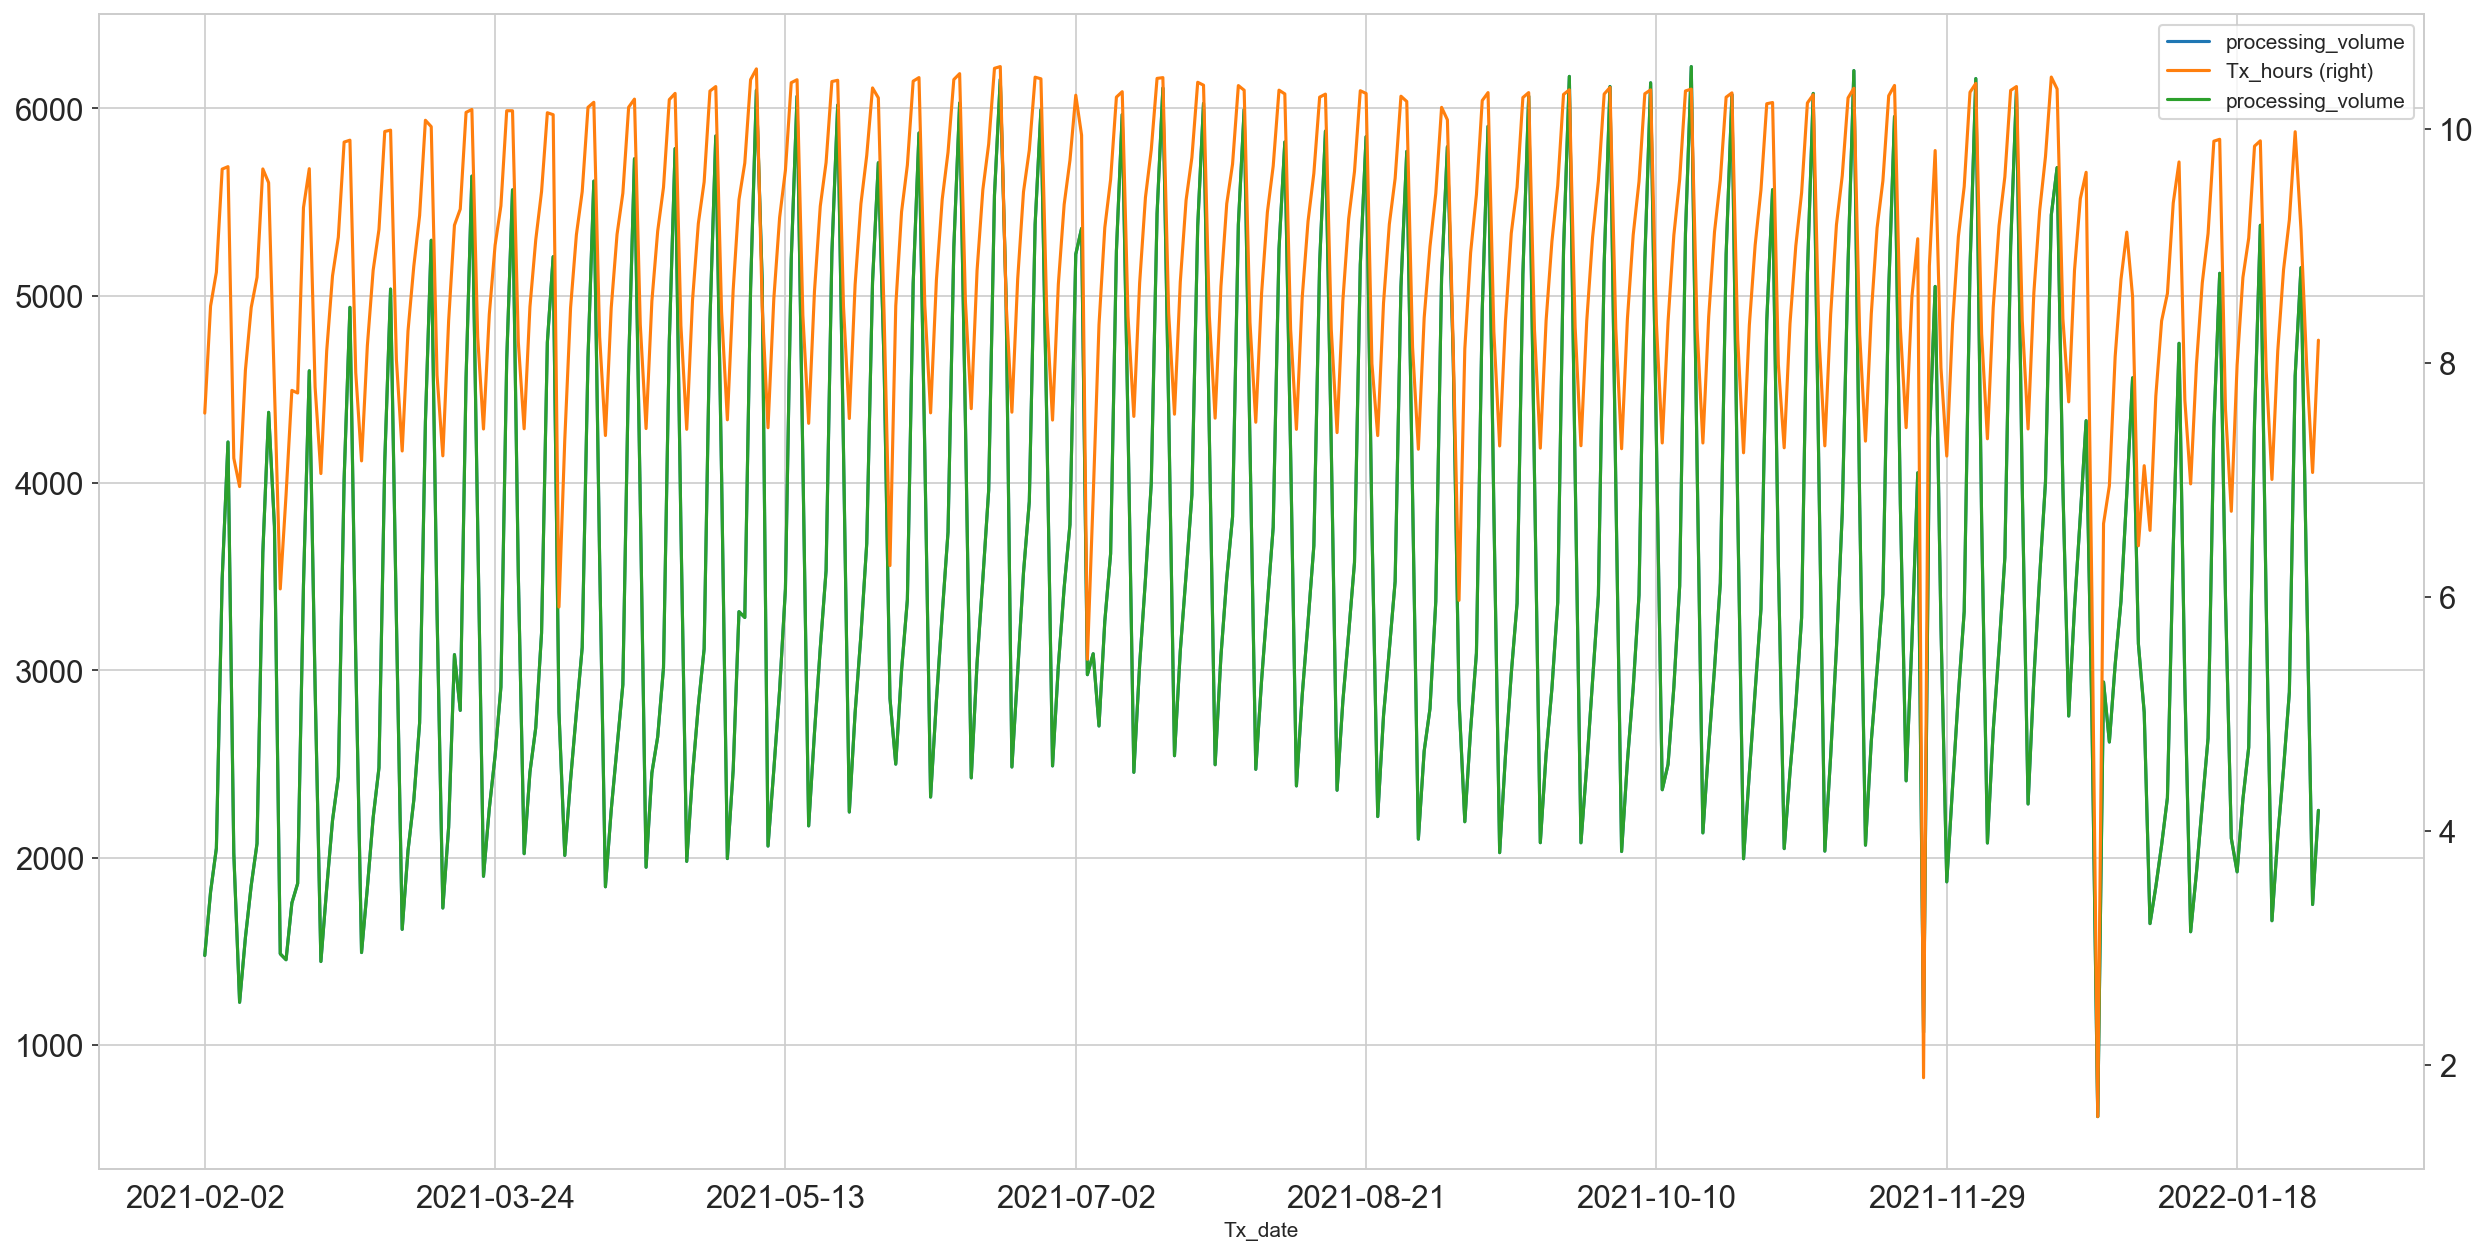

In [227]:
pivot_table = pd.pivot_table(df_train_tx, values=['processing_volume','Tx_hours'],index='Tx_date',aggfunc='mean')
fig, ax = plt.subplots(figsize=(20,10),dpi=150) 
pivot_table.plot( y = 'processing_volume', ax = ax,fontsize = "15")
pivot_table.plot( secondary_y = 'Tx_hours', ax = ax,fontsize = "15") 
# ax.get_legend().remove()
# fig.legend(fontsize="15",bbox_to_anchor=(0.85, 0.3))

# proc_vol_text = 'Avg. Processing Volume'
# hours_text = 'Avg Hours'
# # ax.legend([proc_vol_text, hours_text])
# a=plt.title('Daily',fontsize="20")

In [228]:
pivot_table.nsmallest(2,'processing_volume')

,Tx_hours,processing_volume
Tx_date,,
2021-12-25,1.555124,618.242294
2021-11-25,1.887440,1066.458928


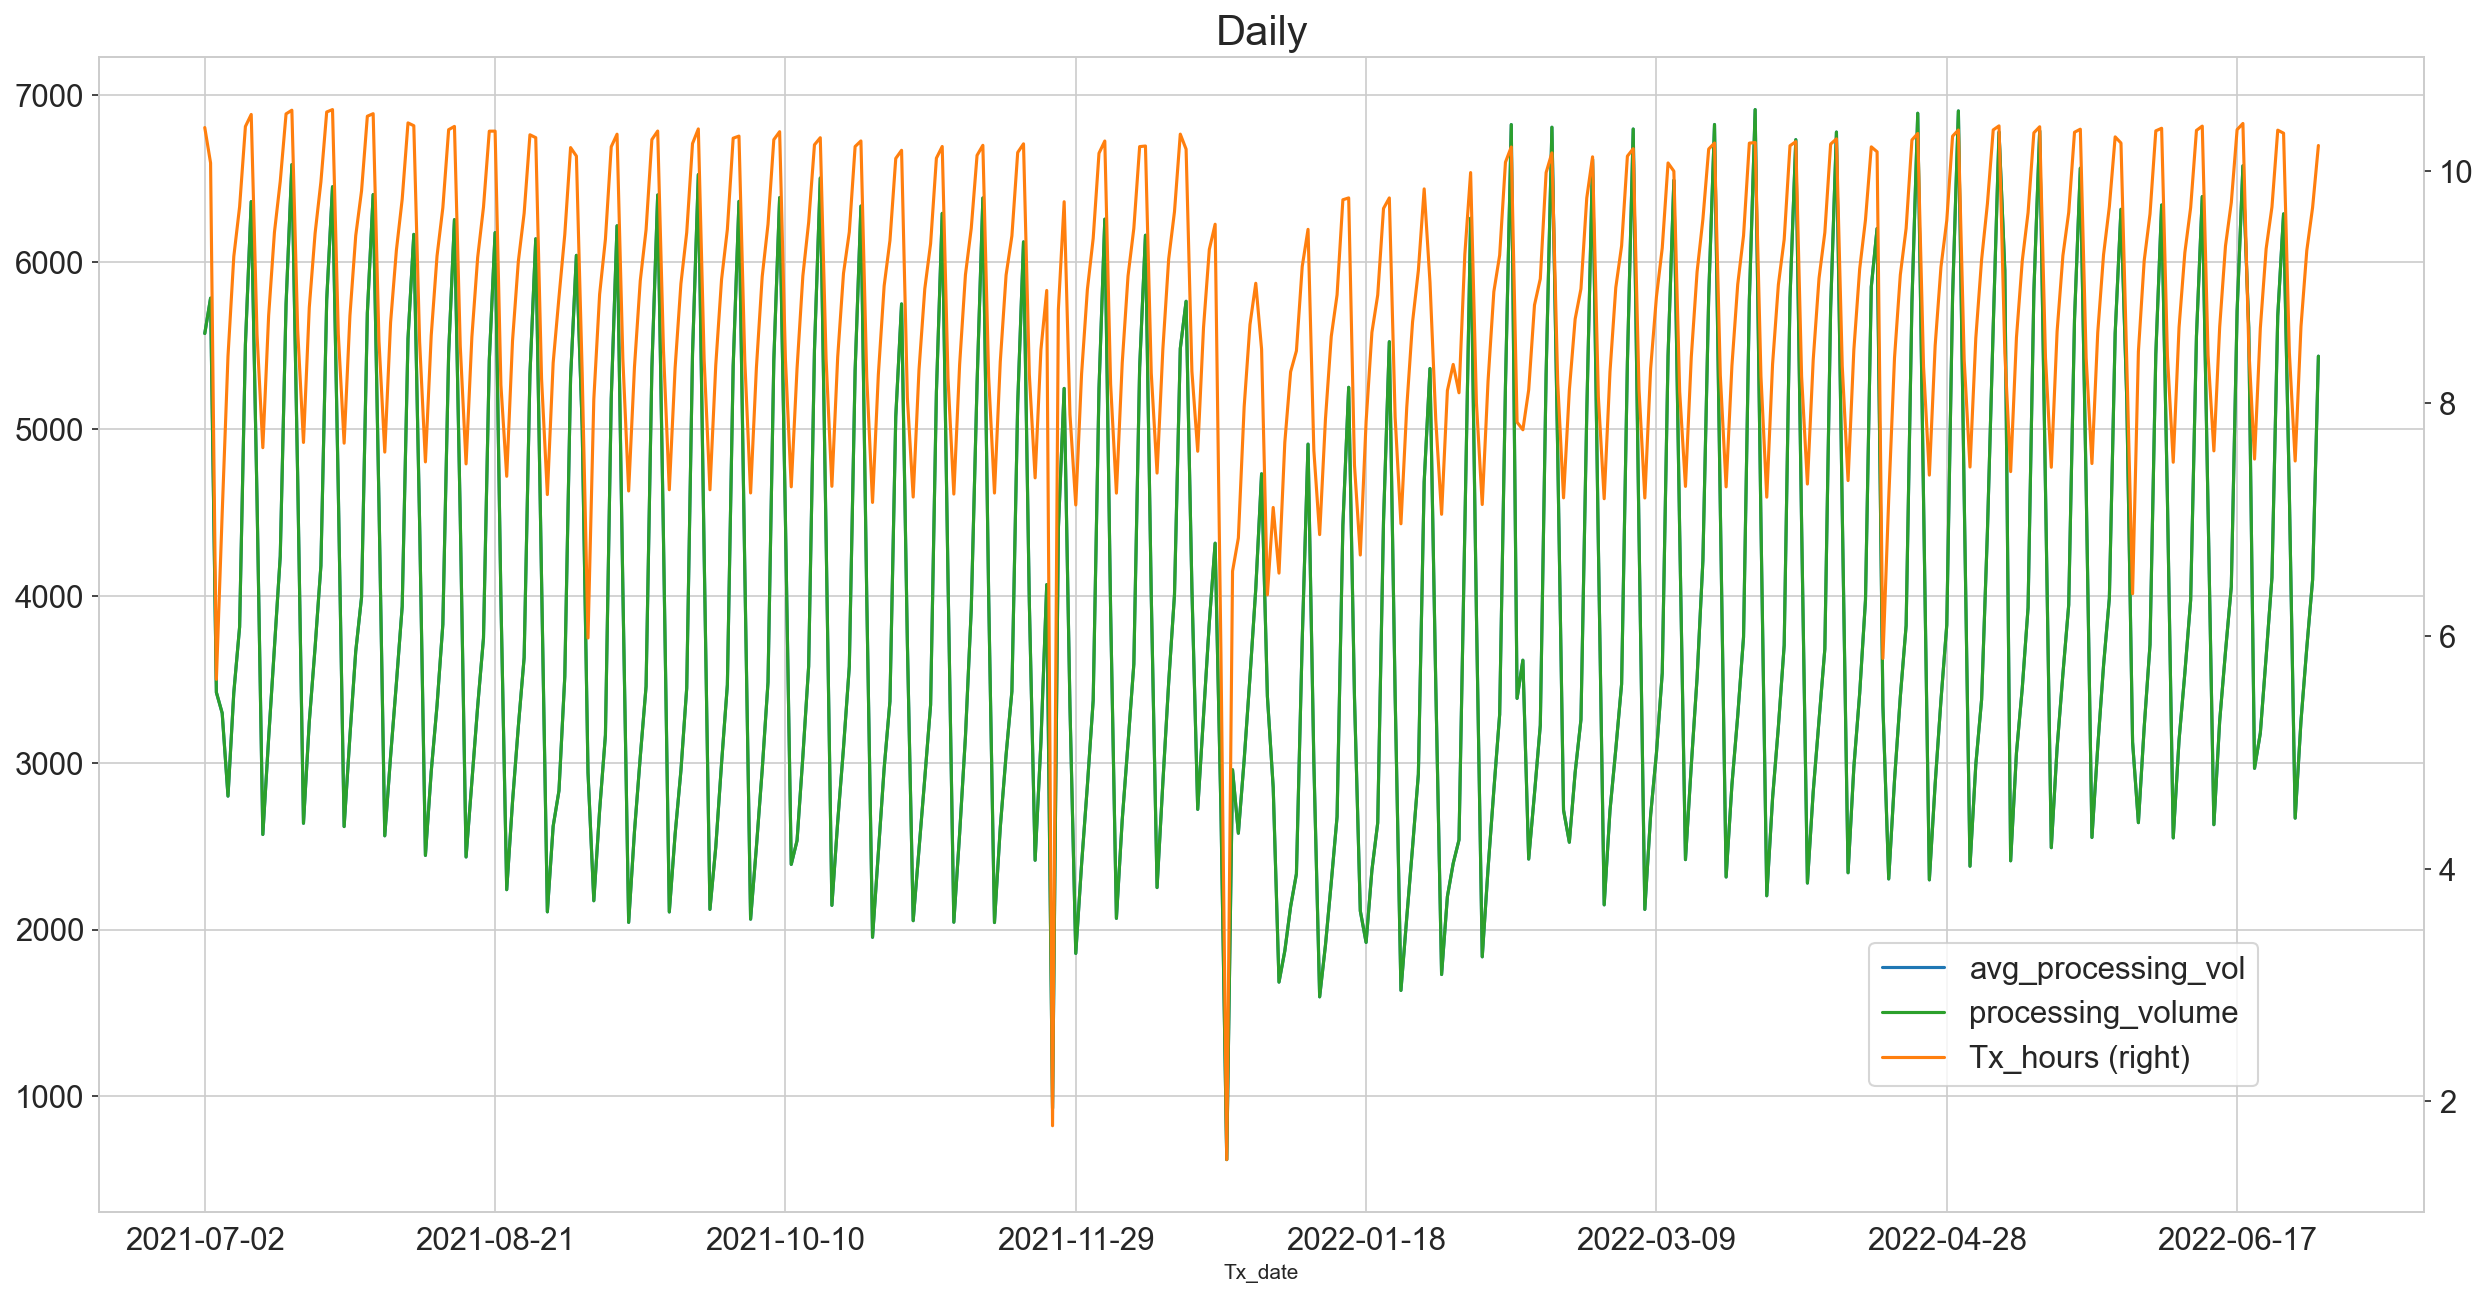

In [229]:
pivot_table = pd.pivot_table(df_holdout_tx, values=['processing_volume','Tx_hours'],index='Tx_date',aggfunc='mean')
fig, ax = plt.subplots(figsize=(20,10),dpi=150) 
pivot_table.plot( y = 'processing_volume', ax = ax,fontsize = "15", label = 'avg_processing_vol')
pivot_table.plot( secondary_y = 'Tx_hours', ax = ax,fontsize = "15", label = 'avg_Tx_hours') 
ax.get_legend().remove()
fig.legend(fontsize="15",bbox_to_anchor=(0.85, 0.3))
a=plt.title('Daily',fontsize="20")

In [230]:
pivot_table.nsmallest(2,'processing_volume')

,Tx_hours,processing_volume
Tx_date,,
2021-12-25,1.499628,621.500582
2021-11-25,1.790793,928.095921


In [232]:
def normalize_ownership_type(x):
    if x == 'SoleProprietorship': return 'Sole Proprietorship'
    elif x == 'PrivateCorporation': return 'Private Corporation'
    elif x == 'PublicCorporation': return 'Public Corporation'
    elif x == 'SECRegulatedCorporation': return 'SEC Regulated Corporation'
    elif x == 'NonProfit': return 'Non Profit'
    elif x == 'Corporate': return 'Corporation'
    else: return x

df_train_acc['Ownership_type'] = df_train_acc['Ownership_type'].apply(normalize_ownership_type)
df_holdout_acc['Ownership_type'] = df_holdout_acc['Ownership_type'].apply(normalize_ownership_type)

In [233]:
df_train_acc['Ownership_type'].value_counts()

LLC                          5761
Corporation                  2318
Private Corporation           928
Partnership                   884
Sole Proprietorship           610
Public Corporation             39
Non Profit                     26
Other                          10
SEC Regulated Corporation       6
Government                      5
Franchise                       3
Financial Institution           1
Trust                           1
Name: Ownership_type, dtype: int64

In [240]:
df_train_acc['Restaurant_cat'] = df_train_acc.Restaurant_catagory.str[:3]
df_holdout_acc['Restaurant_cat'] = df_holdout_acc.Restaurant_catagory.str[:3]

In [241]:
df = df_train_acc
df_unique_n = df.nunique(axis=0).to_frame().rename(columns={0:'unique_values'})
df_unique_n.reset_index(inplace=True)
df_unique_n = df_unique_n.rename(columns = {'index':'feature_name'})

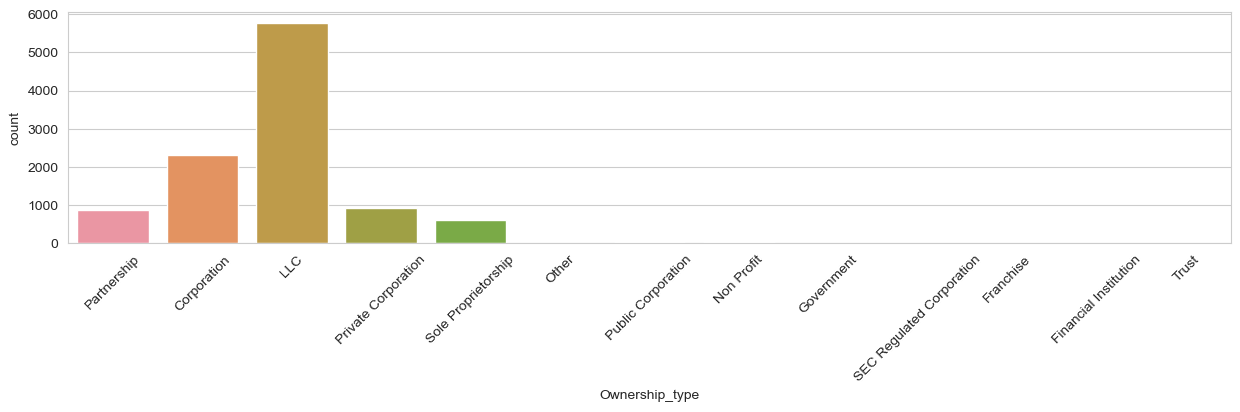

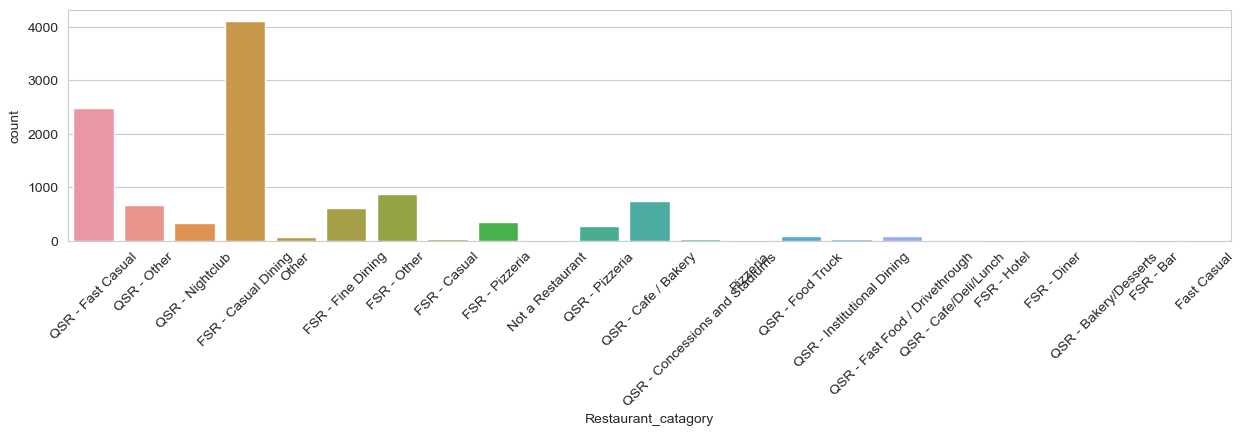

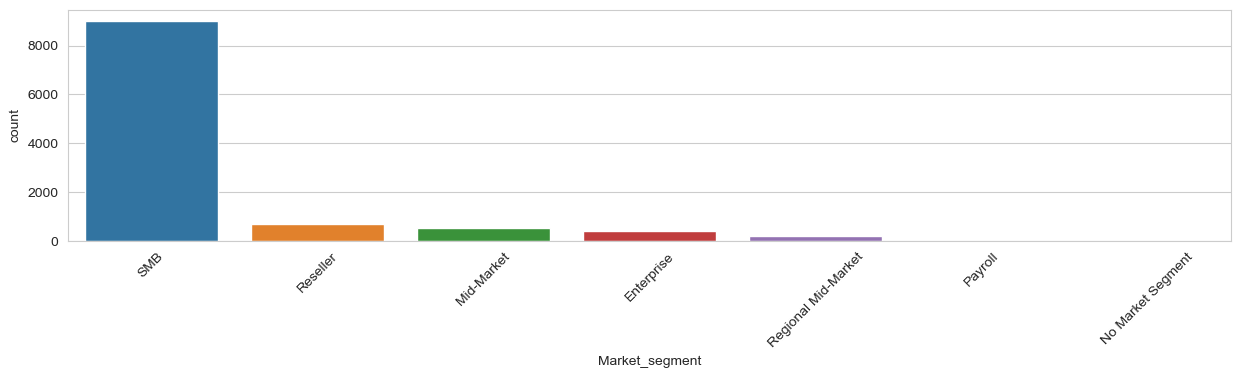

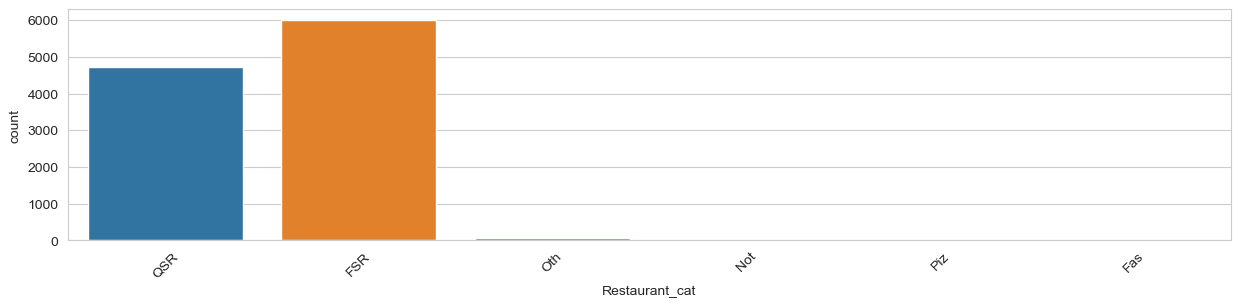

In [242]:
for col in list(df_unique_n[df_unique_n['unique_values']<=30].feature_name):
    plt.figure(figsize=(15,3))
    chart = sns.countplot(x=df[col])
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

# Feature engineering

There are 365 days of daily processing volume and business hours recorded. New features are created based on the daily processing volume and daily business hours.

Trended features are created that capture the following for 30, 90 and 180 days window.  
1. average - Strength
2. total - Strength
3. std deviation - Volatility in business
4. % change between two time periods - Volatility in business
5. minimum - Low point in sales
6. maximum - high point in sales
7. counts of sales and hours below 1 std. This captures the days low business indicating risk.

In [12]:
from datetime import datetime, timedelta
import datetime

def feature_engineering(data,ed_dt):

    datetime_obj = datetime.datetime.strptime(ed_dt, '%Y-%m-%d')
    ed_dt_30days = str(datetime_obj.date() - timedelta(days=30)) # end date minus 30 days
    ed_dt_60days = str(datetime_obj.date() - timedelta(days=60)) # end date minus 60 days
    ed_dt_90days = str(datetime_obj.date() - timedelta(days=90)) # end date minus 90 days
    ed_dt_120days = str(datetime_obj.date() - timedelta(days=120)) # end date minus 120 days
    ed_dt_150days = str(datetime_obj.date() - timedelta(days=150)) # end date minus 150 days
    ed_dt_180days = str(datetime_obj.date() - timedelta(days=180)) # end date minus 180 days
    
    # create filters for recent 30, 90 and 180 days

    def f_30days_ago(x):
        if x >= ed_dt_30days: return 1
        else: return 0

    data['_30days_ago'] = data['Tx_date'].apply(f_30days_ago)

    def f_90days_ago(x):
        if x >= ed_dt_90days: return 1
        else: return 0

    data['_90days_ago'] = data['Tx_date'].apply(f_90days_ago)

    def f_180days_ago(x):
        if x >= ed_dt_180days: return 1
        else: return 0

    data['_180days_ago'] = data['Tx_date'].apply(f_180days_ago)

    def f_180days_monthly(x):
        if x >= ed_dt_30days: return '0-30days'
        elif ed_dt_30days >= x >= ed_dt_60days: return '30-60days_ago'
        elif ed_dt_60days >= x >= ed_dt_90days: return '60-90days_ago'
        elif ed_dt_90days >= x >= ed_dt_120days: return '90-120days_ago'
        elif ed_dt_120days >= x >= ed_dt_150days: return '120-150days_ago'
        elif ed_dt_150days >= x >= ed_dt_180days: return '150-180days_ago'
        else: return '180+days_ago'

    data['monthly'] = data['Tx_date'].apply(f_180days_monthly)
    
    # Create total, average and std deviations for recent 30, 90 and 180 days of processing volume

    temp1 = pd.DataFrame(data[data['_30days_ago']==1].groupby(['Restaurant_ID','_30days_ago'],as_index=False)['processing_volume'].sum()).rename(columns={'processing_volume':'pro_vol_tot_30days'})
    temp1.drop(columns='_30days_ago',inplace=True)
    temp2 = pd.DataFrame(data[data['_30days_ago']==1].groupby(['Restaurant_ID','_30days_ago'],as_index=False)['processing_volume'].mean()).rename(columns={'processing_volume':'pro_vol_avg_30days'})
    temp2.drop(columns='_30days_ago',inplace=True)
    data_flat = pd.merge(temp1,temp2, on=['Restaurant_ID'],how = 'inner')

    temp = pd.DataFrame(data[data['_30days_ago']==1].groupby(['Restaurant_ID','_30days_ago'],as_index=False)['processing_volume'].std()).rename(columns={'processing_volume':'pro_vol_std_30days'})
    temp.drop(columns='_30days_ago',inplace=True)
    data_flat = pd.merge(data_flat,temp, on=['Restaurant_ID'],how = 'inner')

    temp = pd.DataFrame(data[data['_90days_ago']==1].groupby(['Restaurant_ID','_90days_ago'],as_index=False)['processing_volume'].sum()).rename(columns={'processing_volume':'pro_vol_tot_90days'})
    temp.drop(columns='_90days_ago',inplace=True)
    data_flat = pd.merge(data_flat,temp, on=['Restaurant_ID'],how = 'inner')

    temp = pd.DataFrame(data[data['_90days_ago']==1].groupby(['Restaurant_ID','_90days_ago'],as_index=False)['processing_volume'].mean()).rename(columns={'processing_volume':'pro_vol_avg_90days'})
    temp.drop(columns='_90days_ago',inplace=True)
    data_flat = pd.merge(data_flat,temp, on=['Restaurant_ID'],how = 'inner')

    temp = pd.DataFrame(data[data['_90days_ago']==1].groupby(['Restaurant_ID','_90days_ago'],as_index=False)['processing_volume'].std()).rename(columns={'processing_volume':'pro_vol_std_90days'})
    temp.drop(columns='_90days_ago',inplace=True)
    data_flat = pd.merge(data_flat,temp, on=['Restaurant_ID'],how = 'inner')

    temp = pd.DataFrame(data[data['_180days_ago']==1].groupby(['Restaurant_ID','_180days_ago'],as_index=False)['processing_volume'].sum()).rename(columns={'processing_volume':'pro_vol_tot_180days'})
    temp.drop(columns='_180days_ago',inplace=True)
    data_flat = pd.merge(data_flat,temp, on=['Restaurant_ID'],how = 'inner')

    temp = pd.DataFrame(data[data['_180days_ago']==1].groupby(['Restaurant_ID','_180days_ago'],as_index=False)['processing_volume'].mean()).rename(columns={'processing_volume':'pro_vol_avg_180days'})
    temp.drop(columns='_180days_ago',inplace=True)
    data_flat = pd.merge(data_flat,temp, on=['Restaurant_ID'],how = 'inner')

    temp = pd.DataFrame(data[data['_180days_ago']==1].groupby(['Restaurant_ID','_180days_ago'],as_index=False)['processing_volume'].std()).rename(columns={'processing_volume':'pro_vol_std_180days'})
    temp.drop(columns='_180days_ago',inplace=True)
    data_flat = pd.merge(data_flat,temp, on=['Restaurant_ID'],how = 'inner')

    temp = pd.DataFrame(data.groupby(['Restaurant_ID','monthly'],as_index=False)['processing_volume'].mean()).rename(columns={'processing_volume':'pro_vol_avg_monthly'})
    pivot1 = temp.pivot(*temp).rename_axis(index=None, columns=None)
    
    # Create recent 3 (90 days) and 6 (180 days) month processing volume change

    pivot1['pro_vol_6mth_avg_chg_pct'] = ((pivot1['0-30days'] - pivot1['150-180days_ago'])/pivot1['0-30days'])*100
    pivot1['pro_vol_3mth_avg_chg_pct'] = ((pivot1['0-30days'] - pivot1['60-90days_ago'])/pivot1['0-30days'])*100
    pivot1['pro_vol_3mth_avg_max'] = pivot1[['0-30days','30-60days_ago','60-90days_ago']].max(axis=1)
    pivot1['pro_vol_3mth_avg_min'] = pivot1[['0-30days','30-60days_ago','60-90days_ago',]].min(axis=1)
    pivot1['pro_vol_3mth_avg_max_min_diff'] = pivot1['pro_vol_3mth_avg_max'] - pivot1['pro_vol_3mth_avg_min']
    pivot1['pro_vol_6mth_avg_max'] = pivot1[['0-30days','30-60days_ago','60-90days_ago','90-120days_ago',\
                                         '120-150days_ago','150-180days_ago']].max(axis=1)
    pivot1['pro_vol_6mth_avg_min'] = pivot1[['0-30days','30-60days_ago','60-90days_ago','90-120days_ago',\
                                         '120-150days_ago','150-180days_ago']].min(axis=1)
    pivot1['pro_vol_6mth_avg_max_min_diff'] = pivot1['pro_vol_6mth_avg_max'] - pivot1['pro_vol_6mth_avg_min']

    add_list = ['pro_vol_6mth_avg_chg_pct','pro_vol_3mth_avg_chg_pct','pro_vol_3mth_avg_max','pro_vol_3mth_avg_min',\
                'pro_vol_3mth_avg_max_min_diff','pro_vol_6mth_avg_max','pro_vol_6mth_avg_min','pro_vol_6mth_avg_max_min_diff']
    data_flat = pd.merge(data_flat,pivot1[add_list], left_on=['Restaurant_ID'],right_index=True,how = 'inner')
    
    # Create total, average and std deviations for recent 30, 90 and 180 days of hours

    temp = pd.DataFrame(data[data['_30days_ago']==1].groupby(['Restaurant_ID','_30days_ago'],as_index=False)['Tx_hours'].sum()).rename(columns={'Tx_hours':'hours_tot_30days'})
    temp.drop(columns='_30days_ago',inplace=True)
    data_flat = pd.merge(data_flat,temp, on=['Restaurant_ID'],how = 'inner')

    temp = pd.DataFrame(data[data['_30days_ago']==1].groupby(['Restaurant_ID','_30days_ago'],as_index=False)['Tx_hours'].mean()).rename(columns={'Tx_hours':'hours_avg_30days'})
    temp.drop(columns='_30days_ago',inplace=True)
    data_flat = pd.merge(data_flat,temp, on=['Restaurant_ID'],how = 'inner')

    temp = pd.DataFrame(data[data['_30days_ago']==1].groupby(['Restaurant_ID','_30days_ago'],as_index=False)['Tx_hours'].std()).rename(columns={'Tx_hours':'hours_std_30days'})
    temp.drop(columns='_30days_ago',inplace=True)
    data_flat = pd.merge(data_flat,temp, on=['Restaurant_ID'],how = 'inner')

    temp = pd.DataFrame(data[data['_90days_ago']==1].groupby(['Restaurant_ID','_90days_ago'],as_index=False)['Tx_hours'].sum()).rename(columns={'Tx_hours':'hours_tot_90days'})
    temp.drop(columns='_90days_ago',inplace=True)
    data_flat = pd.merge(data_flat,temp, on=['Restaurant_ID'],how = 'inner')

    temp = pd.DataFrame(data[data['_90days_ago']==1].groupby(['Restaurant_ID','_90days_ago'],as_index=False)['Tx_hours'].mean()).rename(columns={'Tx_hours':'hours_avg_90days'})
    temp.drop(columns='_90days_ago',inplace=True)
    data_flat = pd.merge(data_flat,temp, on=['Restaurant_ID'],how = 'inner')

    temp = pd.DataFrame(data[data['_90days_ago']==1].groupby(['Restaurant_ID','_90days_ago'],as_index=False)['Tx_hours'].std()).rename(columns={'Tx_hours':'hours_std_90days'})
    temp.drop(columns='_90days_ago',inplace=True)
    data_flat = pd.merge(data_flat,temp, on=['Restaurant_ID'],how = 'inner')

    temp = pd.DataFrame(data[data['_180days_ago']==1].groupby(['Restaurant_ID','_180days_ago'],as_index=False)['Tx_hours'].sum()).rename(columns={'Tx_hours':'hours_tot_180days'})
    temp.drop(columns='_180days_ago',inplace=True)
    data_flat = pd.merge(data_flat,temp, on=['Restaurant_ID'],how = 'inner')

    temp = pd.DataFrame(data[data['_180days_ago']==1].groupby(['Restaurant_ID','_180days_ago'],as_index=False)['Tx_hours'].mean()).rename(columns={'Tx_hours':'hours_avg_180days'})
    temp.drop(columns='_180days_ago',inplace=True)
    data_flat = pd.merge(data_flat,temp, on=['Restaurant_ID'],how = 'inner')

    temp = pd.DataFrame(data[data['_180days_ago']==1].groupby(['Restaurant_ID','_180days_ago'],as_index=False)['Tx_hours'].std()).rename(columns={'Tx_hours':'hours_std_180days'})
    temp.drop(columns='_180days_ago',inplace=True)
    data_flat = pd.merge(data_flat,temp, on=['Restaurant_ID'],how = 'inner')

    temp = pd.DataFrame(data.groupby(['Restaurant_ID','monthly'],as_index=False)['Tx_hours'].mean()).rename(columns={'Tx_hours':'hours_avg_monthly'})
    pivot1 = temp.pivot(*temp).rename_axis(index=None, columns=None)
    
    # Create recent 3 (90 days) and 6 (180 days) month hours change

    pivot1['hours_6mth_avg_chg_pct'] = ((pivot1['0-30days'] - pivot1['150-180days_ago'])/pivot1['0-30days'])*100
    pivot1['hours_3mth_avg_chg_pct'] = ((pivot1['0-30days'] - pivot1['60-90days_ago'])/pivot1['0-30days'])*100
    
    pivot1['hours_3mth_avg_max'] = pivot1[['0-30days','30-60days_ago','60-90days_ago']].max(axis=1)
    pivot1['hours_3mth_avg_min'] = pivot1[['0-30days','30-60days_ago','60-90days_ago',]].min(axis=1)
    pivot1['hours_3mth_avg_max_min_diff'] = pivot1['hours_3mth_avg_max'] - pivot1['hours_3mth_avg_min']
    pivot1['hours_6mth_avg_max'] = pivot1[['0-30days','30-60days_ago','60-90days_ago','90-120days_ago',\
                                         '120-150days_ago','150-180days_ago']].max(axis=1)
    pivot1['hours_6mth_avg_min'] = pivot1[['0-30days','30-60days_ago','60-90days_ago','90-120days_ago',\
                                         '120-150days_ago','150-180days_ago']].min(axis=1)
    pivot1['hours_6mth_avg_max_min_diff'] = pivot1['hours_6mth_avg_max'] - pivot1['hours_6mth_avg_min']

    add_list = ['hours_6mth_avg_chg_pct','hours_3mth_avg_chg_pct','hours_3mth_avg_max','hours_3mth_avg_min','hours_3mth_avg_max_min_diff',\
               'hours_6mth_avg_max','hours_6mth_avg_min','hours_6mth_avg_max_min_diff']

    data_flat = pd.merge(data_flat,pivot1[add_list], left_on=['Restaurant_ID'],right_index=True,how = 'inner')
    
    # Create counts of processing volume and hours that are less than std deviations for 30, 60 and 180 days.
    
    std_list = [x for x in data_flat.filter(regex='std')]
    keep_list = ['Restaurant_ID'] + std_list 
    data = pd.merge(data,data_flat[keep_list], on=['Restaurant_ID'],how = 'inner')

    def pro_vol_lt_std_30days(df):
        if df['processing_volume'] < df['pro_vol_std_30days'] and df['_30days_ago'] == 1: return 1
        else: return 0

    data['pro_vol_lt_30days_std_count'] = data.apply(pro_vol_lt_std_30days,axis=1)

    def pro_vol_lt_std_90days(df):
        if df['processing_volume'] < df['pro_vol_std_90days'] and df['_90days_ago'] == 1: return 1
        else: return 0

    data['pro_vol_lt_90days_std_count'] = data.apply(pro_vol_lt_std_90days,axis=1)

    def pro_vol_lt_std_180days(df):
        if df['processing_volume'] < df['pro_vol_std_180days'] and df['_180days_ago'] == 1: return 1
        else: return 0

    data['pro_vol_lt_180days_std_count'] = data.apply(pro_vol_lt_std_180days,axis=1)

    def hours_lt_std_30days(df):
        if df['Tx_hours'] < df['hours_std_30days'] and df['_30days_ago'] == 1: return 1
        else: return 0

    data['hours_lt_30days_std_count'] = data.apply(hours_lt_std_30days,axis=1)

    def hours_lt_std_90days(df):
        if df['Tx_hours'] < df['hours_std_90days'] and df['_90days_ago'] == 1: return 1
        else: return 0

    data['hours_lt_90days_std_count'] = data.apply(hours_lt_std_90days,axis=1)

    def hours_lt_std_180days(df):
        if df['Tx_hours'] < df['hours_std_180days'] and df['_180days_ago'] == 1: return 1
        else: return 0

    data['hours_lt_180days_std_count'] = data.apply(hours_lt_std_180days,axis=1)
    
    temp = pd.DataFrame(data[data['_30days_ago']==1].groupby(['Restaurant_ID','_30days_ago'],as_index=False)['pro_vol_lt_30days_std_count'].sum())
    temp.drop(columns='_30days_ago',inplace=True)
    data_flat = pd.merge(data_flat,temp, on=['Restaurant_ID'],how = 'inner')

    temp = pd.DataFrame(data[data['_90days_ago']==1].groupby(['Restaurant_ID','_90days_ago'],as_index=False)['pro_vol_lt_90days_std_count'].sum())
    temp.drop(columns='_90days_ago',inplace=True)
    data_flat = pd.merge(data_flat,temp, on=['Restaurant_ID'],how = 'inner')

    temp = pd.DataFrame(data[data['_180days_ago']==1].groupby(['Restaurant_ID','_180days_ago'],as_index=False)['pro_vol_lt_180days_std_count'].sum())
    temp.drop(columns='_180days_ago',inplace=True)
    data_flat = pd.merge(data_flat,temp, on=['Restaurant_ID'],how = 'inner')

    temp = pd.DataFrame(data[data['_30days_ago']==1].groupby(['Restaurant_ID','_30days_ago'],as_index=False)['hours_lt_30days_std_count'].sum())
    temp.drop(columns='_30days_ago',inplace=True)
    data_flat = pd.merge(data_flat,temp, on=['Restaurant_ID'],how = 'inner')

    temp = pd.DataFrame(data[data['_90days_ago']==1].groupby(['Restaurant_ID','_90days_ago'],as_index=False)['hours_lt_90days_std_count'].sum())
    temp.drop(columns='_90days_ago',inplace=True)
    data_flat = pd.merge(data_flat,temp, on=['Restaurant_ID'],how = 'inner')

    temp = pd.DataFrame(data[data['_180days_ago']==1].groupby(['Restaurant_ID','_180days_ago'],as_index=False)['hours_lt_180days_std_count'].sum())
    temp.drop(columns='_180days_ago',inplace=True)
    data_flat = pd.merge(data_flat,temp, on=['Restaurant_ID'],how = 'inner')
    
    return data_flat

In [13]:
# The end dates of train and holdout datasets.
df_train_tx['Tx_date'].max(), df_holdout_tx['Tx_date'].max()

('2022-02-01', '2022-07-01')

In [14]:
df_train_tx_flat = feature_engineering(df_train_tx,'2022-02-01')
df_holdout_tx_flat = feature_engineering(df_holdout_tx,'2022-07-01')

In [15]:
# Join account and label data
df_train_tx_flat = pd.merge(df_train_tx_flat,df_train_acc,on=['Restaurant_ID'],how='inner')
df_train_tx_flat = pd.merge(df_train_tx_flat,df_train_label,on=['Restaurant_ID'],how='inner')

df_holdout_tx_flat = pd.merge(df_holdout_tx_flat,df_holdout_acc,on=['Restaurant_ID'],how='inner')

In [16]:
print('Not Default vs Default\n',df_train_tx_flat.loan_default.value_counts(dropna=False))
var = round(df_train_tx_flat.loan_default.value_counts(normalize=True,dropna=False).loc[1]*100,2)
print("The event rate is {}%".format(var))

Not Default vs Default
 0.0    9787
1.0    1025
Name: loan_default, dtype: int64
The event rate is 9.48%


In [17]:
df_holdout_tx_flat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4514 entries, 0 to 4513
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Restaurant_ID                  4514 non-null   object 
 1   pro_vol_tot_30days             4514 non-null   float64
 2   pro_vol_avg_30days             4514 non-null   float64
 3   pro_vol_std_30days             4514 non-null   float64
 4   pro_vol_tot_90days             4514 non-null   float64
 5   pro_vol_avg_90days             4514 non-null   float64
 6   pro_vol_std_90days             4514 non-null   float64
 7   pro_vol_tot_180days            4514 non-null   float64
 8   pro_vol_avg_180days            4514 non-null   float64
 9   pro_vol_std_180days            4514 non-null   float64
 10  pro_vol_6mth_avg_chg_pct       4190 non-null   float64
 11  pro_vol_3mth_avg_chg_pct       4514 non-null   float64
 12  pro_vol_3mth_avg_max           4514 non-null   f

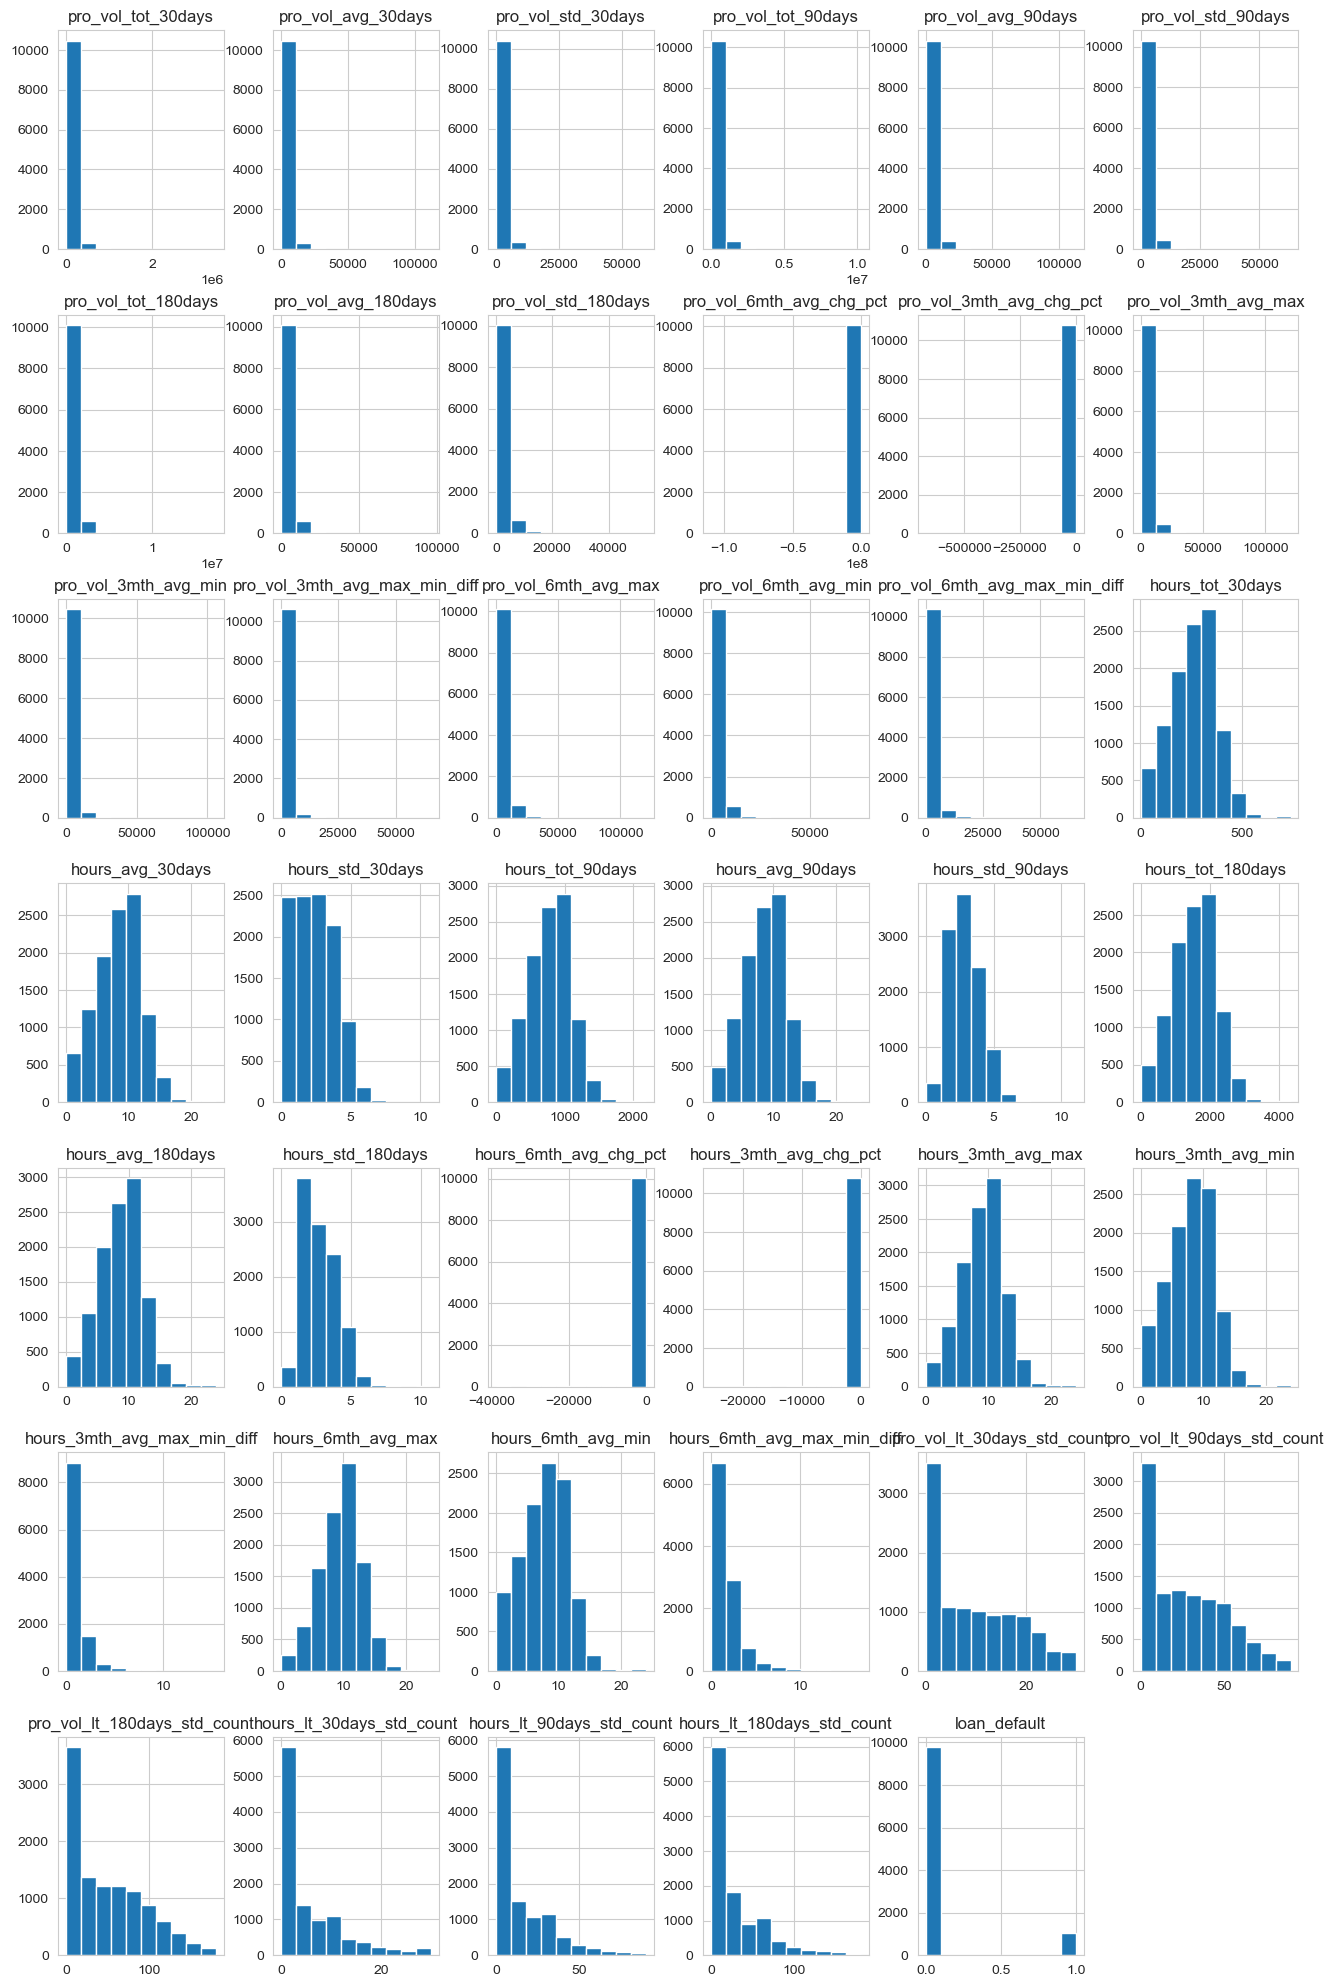

In [18]:
histogram = df_train_tx_flat.hist(figsize=(16,25))

# Create Model Dataset

In [19]:
data = df_train_tx_flat.copy()
y = data.loan_default
remove_list = ['loan_default']
X = data.drop(columns=remove_list)

X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=.25, random_state=42)
X_train.shape, X_test.shape

((8109, 44), (2703, 44))

In [20]:
df_train = pd.merge(X_train,y_train,left_index=True,right_index=True,how='inner')
df_test = pd.merge(X_test,y_test,left_index=True,right_index=True,how='inner')

# Create WoE attributes and calculate their Information Value (IV)

Information value (IV) is a numerical value that quantifies the predictive power of an independent attribute in relation to the binary target.

Advantages:

1. Allows for a monotonic increasing/decreasing or a 'U' shapped relationship with the target.
2. The missing values, similiar to any other bins, get a weight based on the % distribution of events and non-events
3. Inherently scales all the variables to similar ranges.
4. Categorical variables can also converted to WoE without the need for creating multiple dummy variables.
5. Outliers on either end are binned.

Disadvantages:
1. There will be a small loss in the predictive power of the variable due to binning process.

An attribute is divided into bins and the weight of evidence for each bin is calculated as shown in the equation below.

$$ \text{WoE}_i = \log\left( \frac{events_i/total\_events}{non_events_i/total\_non\_events} \right)  
$$

Then, the total information value for the predictor is given by:
$$ \text{IV} = \sum_i \left( \frac{events_i}{total\_events}-\frac{non\_events_i}{total\_non\_events} \right)\cdot \text{WoE}_i
$$

Higher the IV, higher the predictive power.

| Information Value | Variable Predictiveness     |
| ----------------- | --------------------------- |
| Less than 0.02    | Not useful for prediction   |
| 0.02 to 0.1       | Weak predictive Power       |
| 0.1 to 0.3        | Medium predictive Power     |
| 0.3 to 0.5        | Strong predictive Power     |
| \>0.5             | Suspicious Predictive Power |

In [21]:
#create a dictionary with feature name and type "numerical" or "categorical". This will be used by the optbinning process
feature_list = list(X.columns)
feature_list.remove('Restaurant_ID')
feature_dict = {}
for feature in feature_list:
    feature_dict[feature] = str(X[feature].dtype)

for feature in feature_dict.keys():
    # print(feature, feature_type[feature])
    if feature_dict[feature] == 'float64' or feature_dict[feature] == 'int64':
        feature_dict[feature] = 'numerical'
    if feature_dict[feature] == 'object':
        feature_dict[feature] = 'categorical' 
#Sort by having categorical features at the top.
feature_dict=dict(sorted(feature_dict.items(), key=lambda item: item[1]))

Ownership_type IV = 0.067367


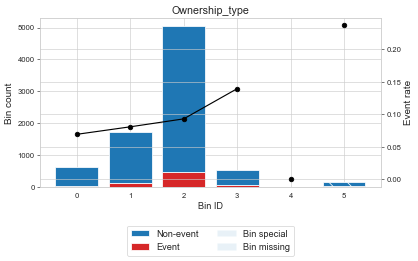

Restaurant_catagory IV = 0.04091


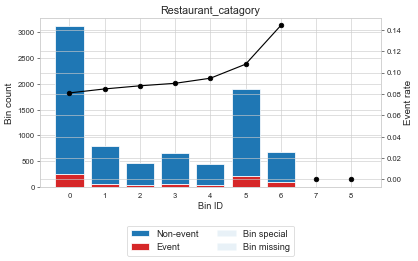

Market_segment IV = 0.043206


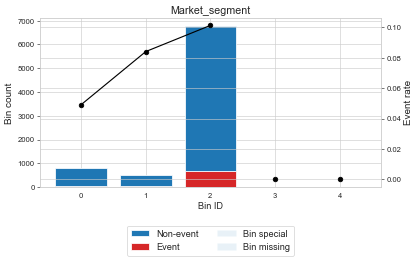

pro_vol_tot_30days IV = 1.185371


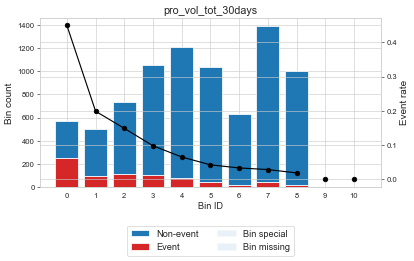

pro_vol_avg_30days IV = 1.185371


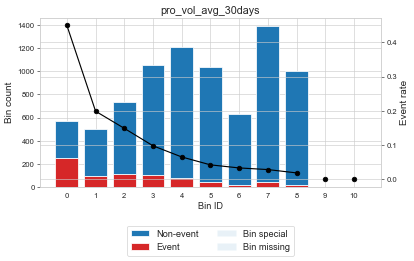

pro_vol_std_30days IV = 0.682618


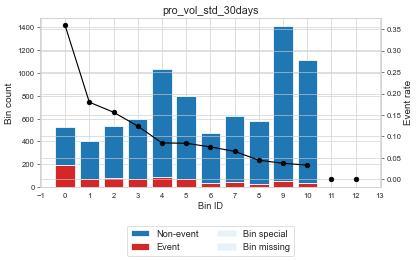

pro_vol_tot_90days IV = 1.022401


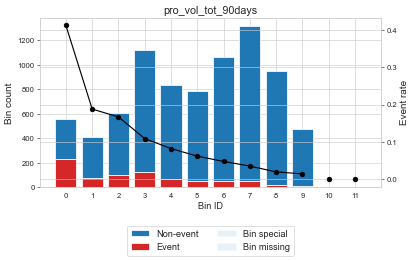

pro_vol_avg_90days IV = 1.022401


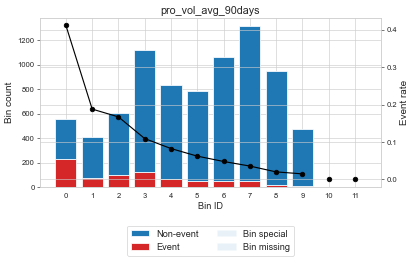

pro_vol_std_90days IV = 0.586663


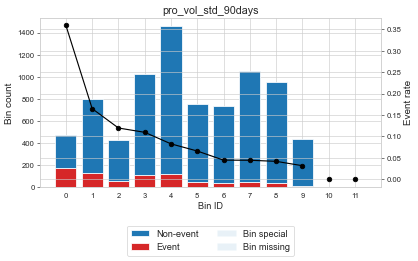

pro_vol_tot_180days IV = 0.882854


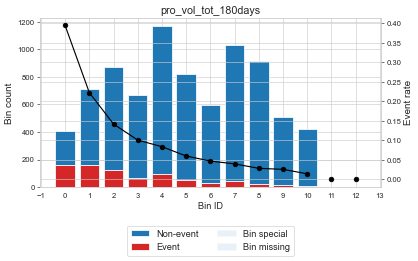

pro_vol_avg_180days IV = 0.893861


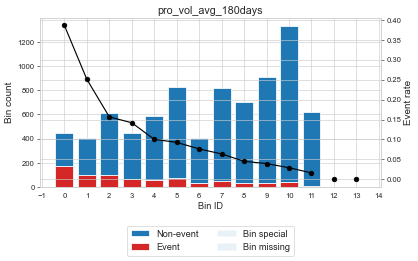

pro_vol_std_180days IV = 0.491532


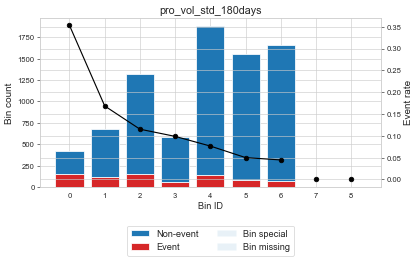

pro_vol_6mth_avg_chg_pct IV = 0.477461


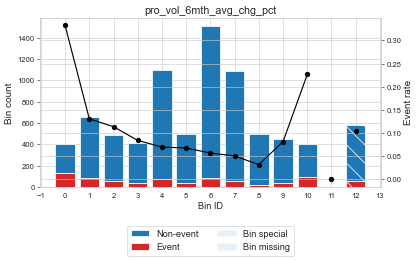

pro_vol_3mth_avg_chg_pct IV = 0.50598


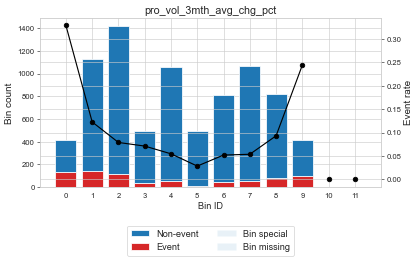

pro_vol_3mth_avg_max IV = 0.904152


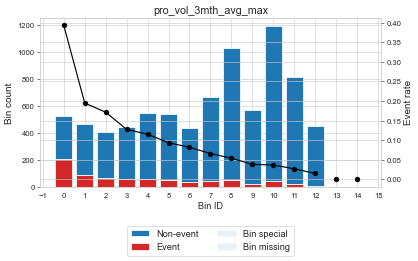

pro_vol_3mth_avg_min IV = 1.238535


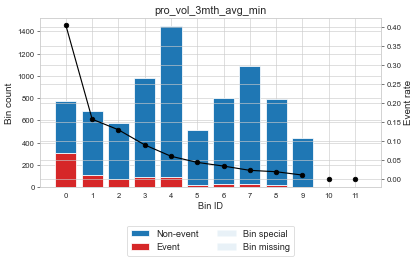

pro_vol_3mth_avg_max_min_diff IV = 0.34523


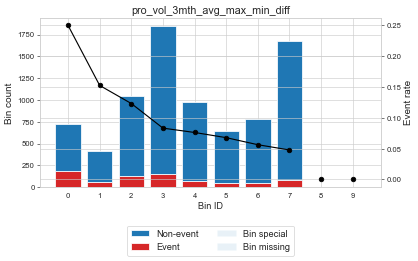

pro_vol_6mth_avg_max IV = 0.735051


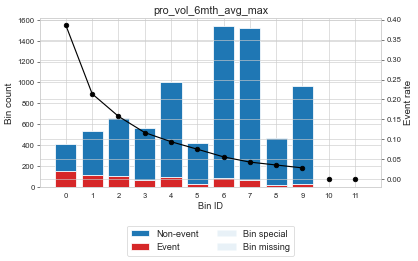

pro_vol_6mth_avg_min IV = 1.220345


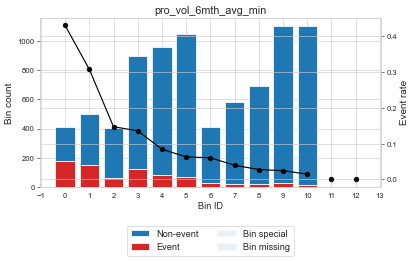

pro_vol_6mth_avg_max_min_diff IV = 0.332209


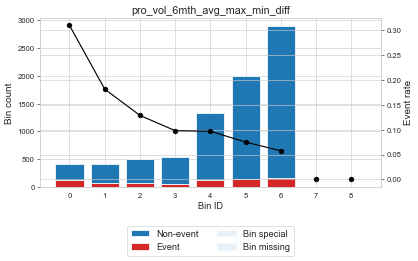

hours_tot_30days IV = 0.953774


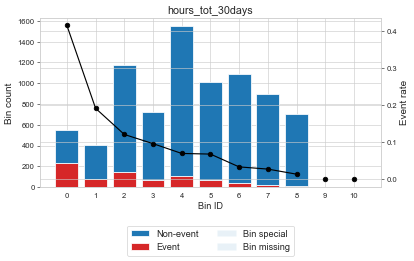

hours_avg_30days IV = 0.953774


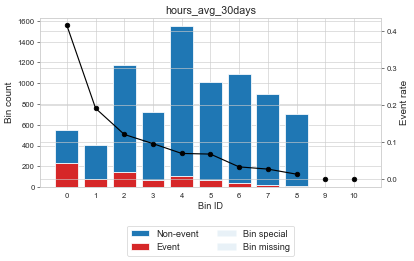

hours_std_30days IV = 0.070172


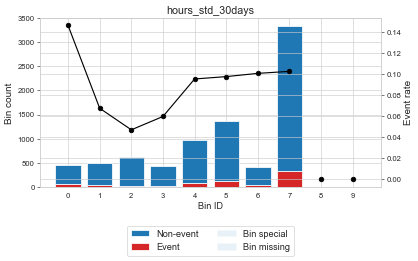

hours_tot_90days IV = 0.827146


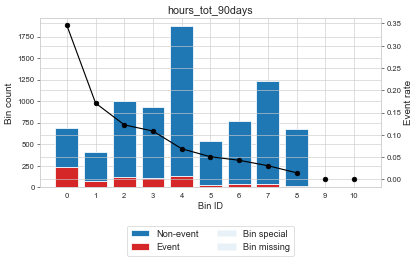

hours_avg_90days IV = 0.827146


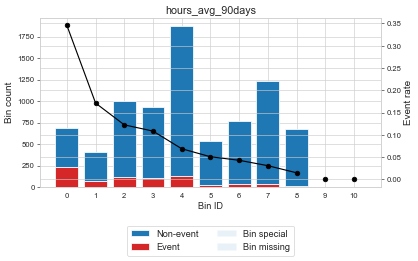

hours_std_90days IV = 0.136663


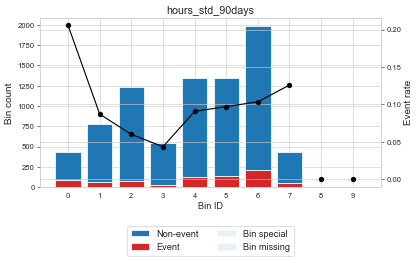

hours_tot_180days IV = 0.728405


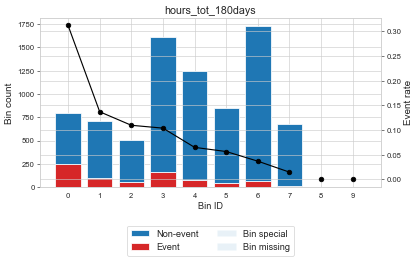

hours_avg_180days IV = 0.763917


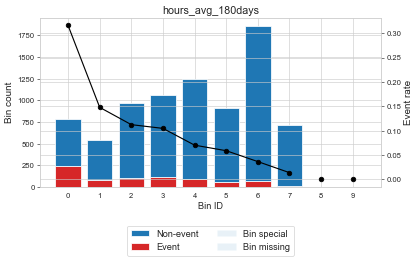

hours_std_180days IV = 0.091004


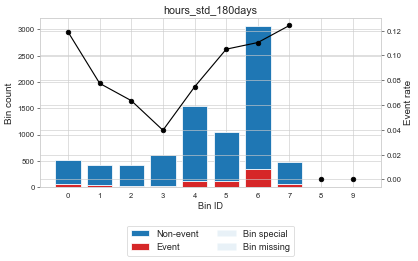

hours_6mth_avg_chg_pct IV = 0.655375


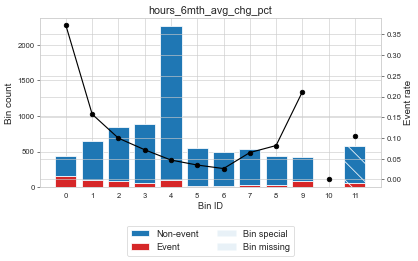

hours_3mth_avg_chg_pct IV = 0.677997


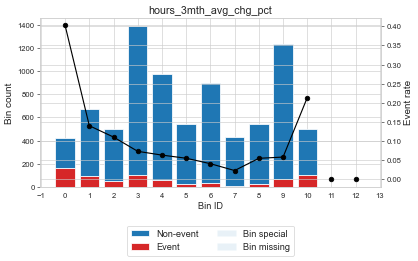

hours_3mth_avg_max IV = 0.718514


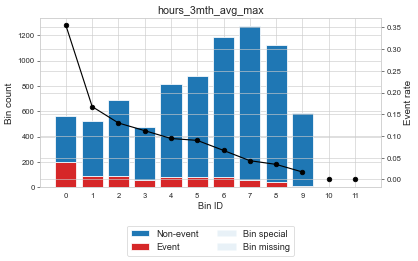

hours_3mth_avg_min IV = 0.993187


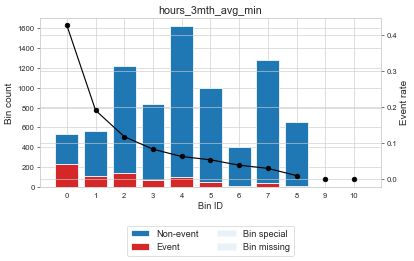

hours_3mth_avg_max_min_diff IV = 0.173892


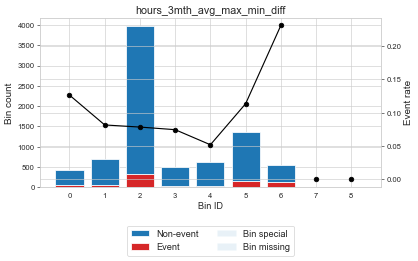

hours_6mth_avg_max IV = 0.61175


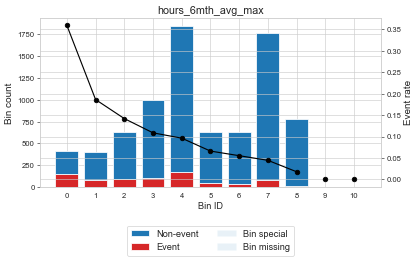

hours_6mth_avg_min IV = 0.972652


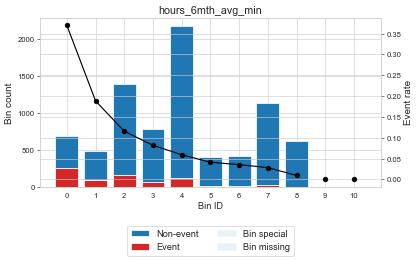

hours_6mth_avg_max_min_diff IV = 0.262534


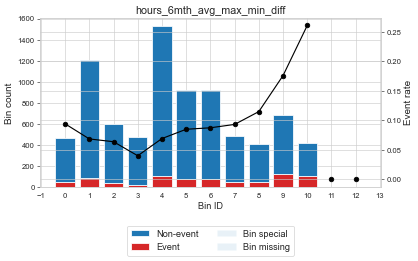

pro_vol_lt_30days_std_count IV = 0.735348


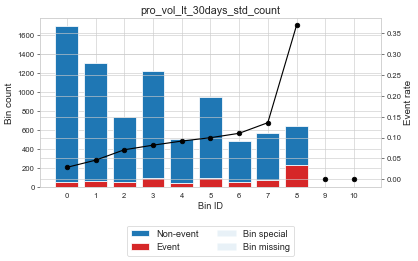

pro_vol_lt_90days_std_count IV = 0.748777


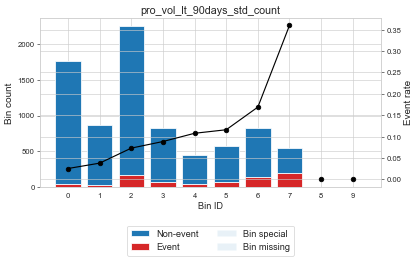

pro_vol_lt_180days_std_count IV = 0.674324


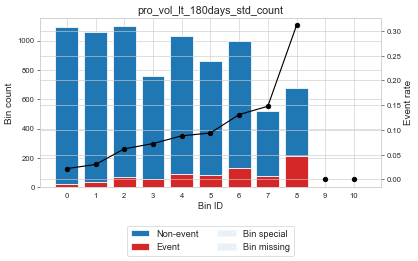

hours_lt_30days_std_count IV = 0.812339


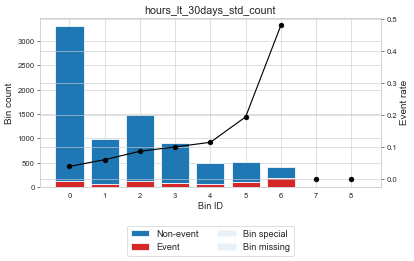

hours_lt_90days_std_count IV = 0.74127


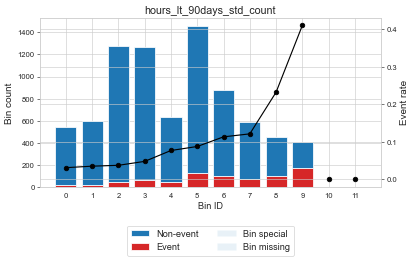

hours_lt_180days_std_count IV = 0.65804


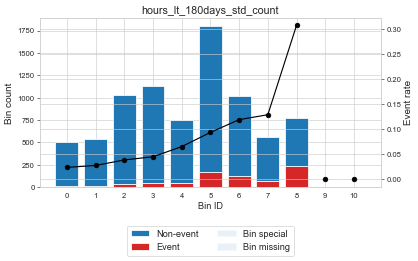

In [22]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 55 # 200 e.g. is really fine, but slower
bin_table = pd.DataFrame()
# feature_type = {'x1':"numerical"}
for feature in feature_dict:
    optb = OptimalBinning(name=feature, dtype=feature_dict[feature], solver="cp")
    optb.fit(X_train[feature], y_train)
    woe_var = feature + '_woe'
    # Add WoE variables to the data
    df_train[woe_var] = optb.transform(df_train[feature], metric="woe")
    df_test[woe_var] = optb.transform(df_test[feature], metric="woe")
    df_holdout_tx_flat[woe_var] = optb.transform(df_holdout_tx_flat[feature], metric="woe")

    binning_table = optb.binning_table
    table = binning_table.build() 
    
    #Vizualize
    print(feature, "IV =", round(table.loc[['Totals']].IV[0],6))
    binning_table.plot(metric="event_rate",style='bin')
    
    table.reset_index(inplace=True)
    table['FeatureName'] = feature
    bin_table = pd.concat([bin_table, table])

bin_table=bin_table.reset_index()
bin_table.drop(columns='level_0',inplace=True)
bin_table.rename(columns = {'index':'Bin_Num'},inplace=True)

In [23]:
totals = bin_table[bin_table['Bin_Num'] == 'Totals']
totals.sort_values(by='IV', ascending=False, na_position='first',inplace=True)
totals[['FeatureName','IV']].to_excel('VariablesSummary.xlsx',index=False)
bin_table.to_excel('BinTable.xlsx',index=False)

# Variable reduction using recursive feature elimination

Recursive feature elimination (RFE) enables to efficiently reduce the number of features in your dataset, without losing the predictive power of the model.

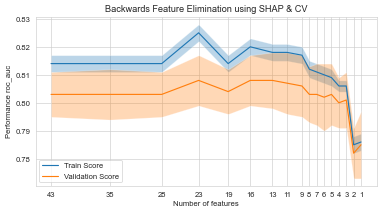

In [24]:
list_woe = [x for x in df_train.columns if x[-3:]=='woe']

clf = GradientBoostingClassifier(random_state=42)

grid = {
    "n_estimators": [40,50, 100, 200, 500], #The number of boosting stages to perform
    "max_leaf_nodes": [2, 5, 10, 20], # Grow trees with max_leaf_nodes in best-first fashion.
    "learning_rate": [0.01,0.1,0.5,1], #Learning rate shrinks the contribution of each tree by learning_rate
    "min_samples_leaf":[0.02,0.05], #The minimum number of samples required to be at a leaf node.
}

grid_search = HalvingGridSearchCV(estimator=clf, param_grid=grid, n_jobs=-1, cv=5, \
                                  scoring='roc_auc',error_score=0,random_state=42, refit=True)
grid_search.fit(df_train[list_woe], y_train)

shap_elimination = ShapRFECV(clf=grid_search, step=0.2, cv=5, scoring='roc_auc', n_jobs=-1)
report = shap_elimination.fit_compute(df_train[list_woe], y_train,check_additivity=False)
performance_plot = shap_elimination.plot()

In [25]:
report[report['num_features']<20][['num_features', 'features_set', 'train_metric_mean','val_metric_mean']]

,num_features,features_set,train_metric_mean,val_metric_mean
5,19,"[pro_vol_3mth_avg_max_min_diff_woe, hours_6mth...",0.814,0.804
6,16,"[hours_6mth_avg_max_min_diff_woe, hours_lt_30d...",0.820,0.808
7,13,"[hours_lt_30days_std_count_woe, hours_std_90da...",0.818,0.808
8,11,"[hours_3mth_avg_max_min_diff_woe, pro_vol_lt_9...",0.818,0.807
9,9,"[hours_3mth_avg_max_min_diff_woe, hours_std_90...",0.817,0.806
10,8,"[hours_3mth_avg_max_min_diff_woe, pro_vol_3mth...",0.812,0.803
11,7,"[hours_6mth_avg_min_woe, pro_vol_avg_30days_wo...",0.811,0.803
12,6,"[hours_6mth_avg_min_woe, hours_6mth_avg_chg_pc...",0.810,0.802
13,5,"[hours_6mth_avg_chg_pct_woe, hours_avg_30days_...",0.809,0.803
14,4,"[pro_vol_3mth_avg_min_woe, pro_vol_avg_30days_...",0.806,0.800


In [26]:
list_gbm = shap_elimination.get_reduced_features_set(num_features=13)

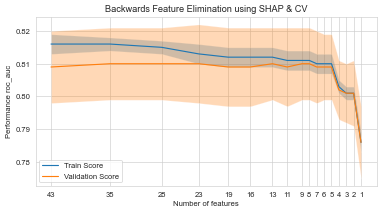

,num_features,features_set,train_metric_mean,val_metric_mean
7,13,"[hours_6mth_avg_max_min_diff_woe, hours_lt_30d...",0.812,0.810
8,11,"[pro_vol_lt_90days_std_count_woe, hours_6mth_a...",0.811,0.809
9,9,"[pro_vol_lt_90days_std_count_woe, hours_6mth_a...",0.811,0.810
10,8,"[pro_vol_lt_90days_std_count_woe, hours_6mth_a...",0.811,0.810
11,7,"[hours_6mth_avg_max_min_diff_woe, pro_vol_avg_...",0.810,0.809
12,6,"[hours_6mth_avg_max_min_diff_woe, hours_lt_30d...",0.810,0.809
13,5,"[hours_6mth_avg_max_min_diff_woe, hours_lt_30d...",0.810,0.809
14,4,"[hours_lt_30days_std_count_woe, pro_vol_3mth_a...",0.803,0.802
15,3,"[hours_lt_30days_std_count_woe, pro_vol_3mth_a...",0.801,0.801
16,2,"[hours_lt_30days_std_count_woe, pro_vol_3mth_a...",0.801,0.801


In [27]:
clf_lr = LogisticRegression(n_jobs=-1,random_state=42)

shap_elimination = ShapRFECV( clf=clf_lr, step=0.2, cv=5, scoring='roc_auc', \
                             n_jobs=-1) 
report = shap_elimination.fit_compute(df_train[list_woe], y_train)
performance_plot = shap_elimination.plot()
report[report['num_features']<15][['num_features', 'features_set', \
                                   'train_metric_mean','val_metric_mean']]

In [28]:
list_lr = shap_elimination.get_reduced_features_set(num_features=8)

In [29]:
remove_list = ['hours_lt_30days_std_count_woe','pro_vol_std_180days_woe','pro_vol_3mth_avg_min_woe']
list_lr = [x for x in list_lr if x not in remove_list]

# Logistic regression model

A logistic regression model is developed to establish a baseline for the predictive power of the data. The logistic function lends itself to predicting binary outcome because its range is restricted between 0 and 1.

Assumptions of Logistic Regression:
1. Binary logistic regression requires the dependent variable to be binary
2. Observations to be independent of each other.
3. Little or no multicollinearity among the independent variables.
4. Assumes linearity of independent variables and log odds of the target variable
5. Typically requires a large sample size. In this case, sample size of 10812 and event size of 1025 is sufficient for the purpose of employing logistic regression.



In [145]:
#Instatiate Logistic Regression Classifier
clf_lr = LogisticRegression(random_state=42)

# define grid search
grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
         'penalty': ['l1','l2'],
         'C': [100, 10, 1.0, 0.1, 0.01]}

grid_search = HalvingGridSearchCV(estimator=clf_lr, param_grid=grid, n_jobs=-1, cv=5, \
                                  scoring='roc_auc',error_score=0,random_state=42)
grid_search.fit(df_train[list_lr], y_train)
# grid_result = grid_search.fit(X, y)

best_clf = grid_search.best_estimator_
# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

df_train['y_pred'] = best_clf.predict_proba(df_train[list_lr])[:,1]
df_test['y_pred'] = best_clf.predict_proba(df_test[list_lr])[:,1]
df_holdout_tx_flat['pred'] = best_clf.predict_proba(df_holdout_tx_flat[list_lr])[:,1]

Best: 0.802041 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [146]:
print('Train Actual : ', df_train['loan_default'].sum(),', Train Predicted : %.1f'%df_train['y_pred'].sum())
print('Test Actual : ', df_test['loan_default'].sum(),', Test Predicted : %.1f'%df_test['y_pred'].sum())

Train Actual :  769.0 , Train Predicted : 791.0
Test Actual :  256.0 , Test Predicted : 260.9


### Expected vs Actual Default Rate

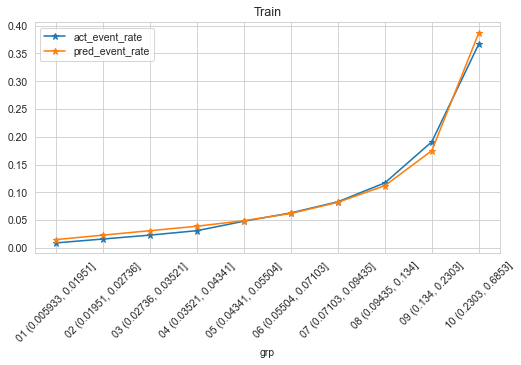

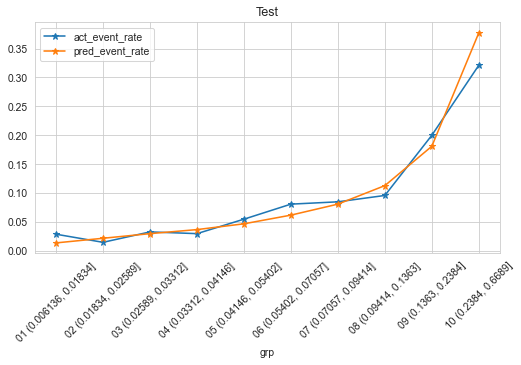

In [147]:
ror_train = exp_vs_act(df_train,'y_pred','loan_default','Train')
ror_test = exp_vs_act(df_test,'y_pred','loan_default','Test')

In [148]:
ror_test

,grp,non_events,events,pred_events,total,act_event_rate,pred_event_rate,% event dist,% non-event dist,% total dist,WoE,IV
0,"01 (0.006136, 0.01834]",264,8,3.9,272,0.029,0.014,3.1,10.8,10.1,1.24,0.09
1,"02 (0.01834, 0.02589]",265,4,6.0,269,0.015,0.022,1.6,10.8,10.0,1.94,0.18
2,"03 (0.02589, 0.03312]",261,9,8.0,270,0.033,0.030,3.5,10.7,10.0,1.11,0.08
3,"04 (0.03312, 0.04146]",262,8,10.1,270,0.030,0.037,3.1,10.7,10.0,1.23,0.09
4,"05 (0.04146, 0.05402]",256,15,12.8,271,0.055,0.047,5.9,10.5,10.0,0.58,0.03
5,"06 (0.05402, 0.07057]",248,22,16.7,270,0.081,0.062,8.6,10.1,10.0,0.16,0.00
6,"07 (0.07057, 0.09414]",247,23,22.0,270,0.085,0.081,9.0,10.1,10.0,0.12,0.00
7,"08 (0.09414, 0.1363]",244,26,30.5,270,0.096,0.113,10.2,10.0,10.0,-0.02,0.00
8,"09 (0.1363, 0.2384]",216,54,48.8,270,0.200,0.181,21.1,8.8,10.0,-0.87,0.11
9,"10 (0.2384, 0.6689]",184,87,102.1,271,0.321,0.377,34.0,7.5,10.0,-1.51,0.40


### ROC curve

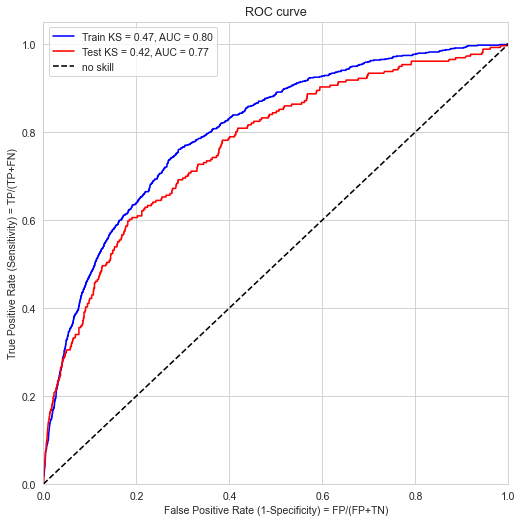

In [149]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
plot_auc2(ax, y_train, df_train['y_pred'], y_test, df_test['y_pred'])

In [150]:
# Search optimal threshold
# search thresholds for imbalanced classification
from numpy import arange
from numpy import argmax

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')
# keep probabilities for the positive outcome only
probs = df_test['y_pred']
# define thresholds
thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.166, F-Score=0.36469


In [151]:
print("Training Metrics")
performance_metrics(y_train,df_train['y_pred'],thresholds[ix])
print("\n","Test Metrics")
performance_metrics(y_test,df_test['y_pred'],thresholds[ix])

Training Metrics
Performance Metrics

Accuracy             = 0.847
Balanced_Accuracy    = 0.701
Precision            = 0.314
Recall               = 0.521
Rmse                 = 0.272 

Confusion Matrix
               Predicted     
                   False True
Observed False      6464  876
         True        368  401

 Test Metrics
Performance Metrics

Accuracy             = 0.838
Balanced_Accuracy    = 0.683
Precision            = 0.290
Recall               = 0.492
Rmse                 = 0.275 

Confusion Matrix
               Predicted     
                   False True
Observed False      2138  309
         True        130  126


### Variable contribution

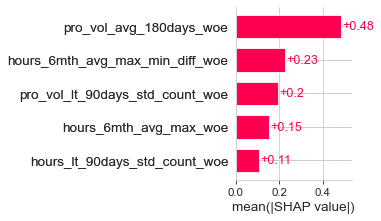

In [152]:
explainer = shap.Explainer(best_clf, df_train[list_lr], feature_names=[list_lr])
shap_values = explainer(df_test[list_lr])
fig = plt.figure()
shap.plots.bar(shap_values, max_display=20,show = False)
plt.gcf().set_size_inches(2,3)
plt.show()

In [153]:
feature_names = shap_values.feature_names
shap_df = pd.DataFrame(shap_values.values, columns=feature_names)
vals = np.abs(shap_df.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['col_name', 'feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)

In [154]:
shap_importance

,col_name,feature_importance_vals
2,pro_vol_avg_180days_woe,0.484326
1,hours_6mth_avg_max_min_diff_woe,0.225175
0,pro_vol_lt_90days_std_count_woe,0.195044
3,hours_6mth_avg_max_woe,0.154615
4,hours_lt_90days_std_count_woe,0.109028


### Low multicolinearity among predictors

In [155]:
# importing the variance_inflation_factor() function
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF dataframe
vif_data = pd.DataFrame()
vif_data['Feature'] = df_test[list_lr].columns
  
# calculating VIF for each feature
vif_data['VIF_Train']= [variance_inflation_factor(df_train[list_lr].values, i) for i in range(len(df_train[list_lr].columns))]
vif_data['VIF_Test']= [variance_inflation_factor(df_test[list_lr].values, i) for i in range(len(df_test[list_lr].columns))]

# printing the VIF of each feature
vif_data.style.background_gradient(cmap='YlOrRd').set_properties(**{'font-size': '12px'})

,Feature,VIF_Train,VIF_Test
0,pro_vol_lt_90days_std_count_woe,2.782376,2.798786
1,hours_6mth_avg_max_min_diff_woe,1.257383,1.263116
2,pro_vol_avg_180days_woe,1.411146,1.446710
3,hours_6mth_avg_max_woe,2.737281,2.776582
4,hours_lt_90days_std_count_woe,3.773565,3.680993


### Low pairwise correlation

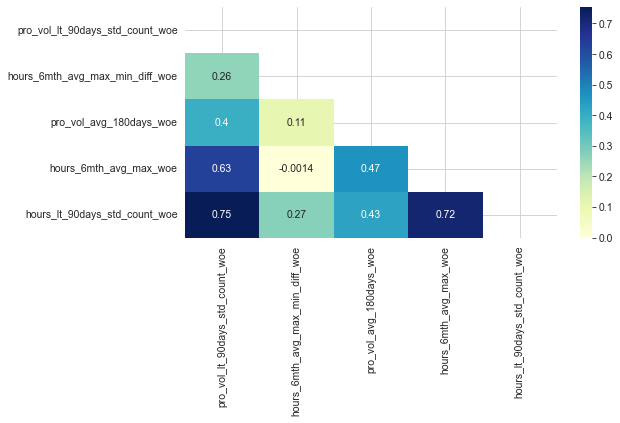

In [156]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 75 # 200 e.g. is really fine, but slower
mask = np.triu(np.ones_like(df_train[list_lr].corr()))
# plotting a triangle correlation heatmap
dataplot = sns.heatmap(df_test[list_lr].corr(), cmap="YlGnBu", annot=True, mask=mask)
# displaying heatmap
plt.show()

In [157]:
#Export Holdout data predictions
df_holdout_tx_flat[['Restaurant_ID','pred']].to_csv('holdout_for_prediction_lr.csv',index=False)

# Gradient boosting classifier

Gradient boosting works by building weak esitmators prediction models sequentially where each model tries to predict the error left over by the previous model. Because of this, the algorithm has the tendency to overfit. Hyperparameter tuning is used to control the overfitting.
1. Keeping the maximum depth small.
2. Restricting the max_leaf_nodes.
3. Restricting the contribution of each tree via learing rate.

The loss function to be optimized is ‘log_loss’, the same as used in logistic regression.

In [158]:
clf = GradientBoostingClassifier(random_state=42)

grid = {
    "n_estimators": [40,50, 100, 200, 500], #The number of boosting stages to perform
    "max_leaf_nodes": [2, 5, 10, 20], # Grow trees with max_leaf_nodes in best-first fashion.
    "learning_rate": [0.01,0.1,0.5,1], #Learning rate shrinks the contribution of each tree by learning_rate
    "min_samples_leaf":[0.02,0.05], #The minimum number of samples required to be at a leaf node.
}

grid_search = HalvingGridSearchCV(estimator=clf, param_grid=grid, n_jobs=-1, cv=5, \
                                  scoring='roc_auc',error_score=0,random_state=42, refit=True)
grid_search.fit(df_train[list_gbm], y_train)

best_clf = grid_search.best_estimator_
# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

df_train['y_pred'] = np.ndarray.round(best_clf.predict_proba(df_train[list_gbm])[:,1],4)
df_test['y_pred'] = np.ndarray.round(best_clf.predict_proba(df_test[list_gbm])[:,1],4)
df_holdout_tx_flat['pred'] = np.ndarray.round(best_clf.predict_proba(df_holdout_tx_flat[list_gbm])[:,1],4)

Best: 0.807636 using {'learning_rate': 0.1, 'max_leaf_nodes': 2, 'min_samples_leaf': 0.05, 'n_estimators': 100}


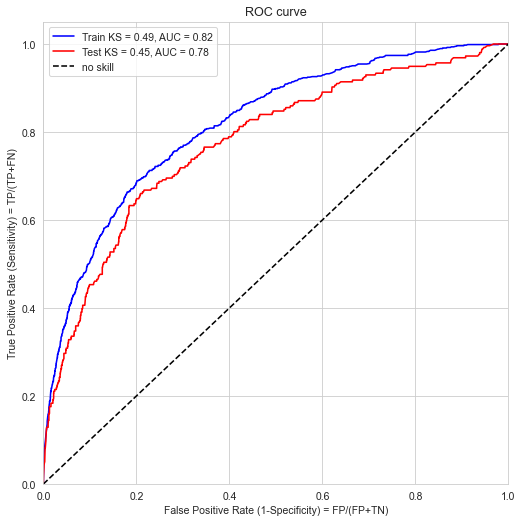

In [170]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
plot_auc2(ax, y_train, df_train['y_pred'], y_test, df_test['y_pred'])

In [160]:
print('Train Actual : ', df_train['loan_default'].sum(),', Train Predicted : %.1f'%df_train['y_pred'].sum())
print('Test Actual : ', df_test['loan_default'].sum(),', Test Predicted : %.1f'%df_test['y_pred'].sum())

Train Actual :  769.0 , Train Predicted : 769.1
Test Actual :  256.0 , Test Predicted : 252.8


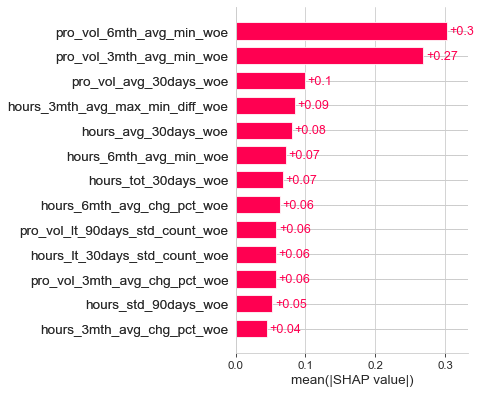

In [161]:
explainer = shap.Explainer(best_clf, df_train[list_gbm], feature_names=[list_gbm])
shap_values = explainer(df_test[list_gbm])
fig = plt.figure()
shap.plots.bar(shap_values, max_display=20,show = False)
plt.gcf().set_size_inches(4,6)
plt.show()

In [162]:
# Search optimal threshold
# search thresholds for imbalanced classification
from numpy import arange
from numpy import argmax

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')
# keep probabilities for the positive outcome only
probs = df_test['y_pred']
# define thresholds
thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.164, F-Score=0.37724


In [163]:
print("Training Metrics")
performance_metrics(y_train,df_train['y_pred'],thresholds[ix])
print("\n")
print("Test Metrics")
performance_metrics(y_test,df_test['y_pred'],thresholds[ix])

Training Metrics
Performance Metrics

Accuracy             = 0.867
Balanced_Accuracy    = 0.702
Precision            = 0.355
Recall               = 0.498
Rmse                 = 0.266 

Confusion Matrix
               Predicted     
                   False True
Observed False      6644  696
         True        386  383


Test Metrics
Performance Metrics

Accuracy             = 0.858
Balanced_Accuracy    = 0.677
Precision            = 0.323
Recall               = 0.453
Rmse                 = 0.274 

Confusion Matrix
               Predicted     
                   False True
Observed False      2204  243
         True        140  116


In [164]:
feature_names = shap_values.feature_names
shap_df = pd.DataFrame(shap_values.values, columns=feature_names)
vals = np.abs(shap_df.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['col_name', 'feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)

In [165]:
shap_importance

,col_name,feature_importance_vals
6,pro_vol_6mth_avg_min_woe,0.302248
12,pro_vol_3mth_avg_min_woe,0.269201
5,pro_vol_avg_30days_woe,0.099156
7,hours_3mth_avg_max_min_diff_woe,0.085115
2,hours_avg_30days_woe,0.080367
10,hours_6mth_avg_min_woe,0.071426
3,hours_tot_30days_woe,0.067459
11,hours_6mth_avg_chg_pct_woe,0.062901
8,pro_vol_lt_90days_std_count_woe,0.058207
0,hours_lt_30days_std_count_woe,0.058069


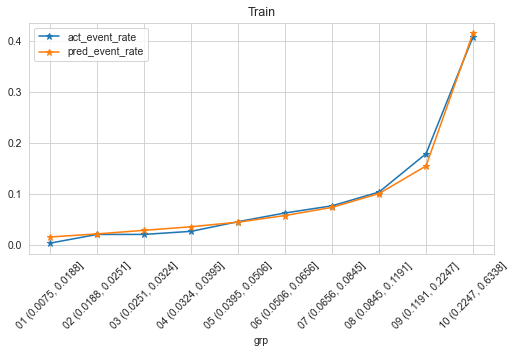

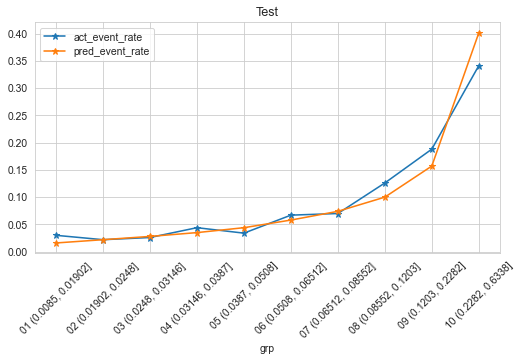

In [166]:
ror_train = exp_vs_act(df_train,'y_pred','loan_default','Train')
ror_test = exp_vs_act(df_test,'y_pred','loan_default','Test')

In [167]:
ror_test

,grp,non_events,events,pred_events,total,act_event_rate,pred_event_rate,% event dist,% non-event dist,% total dist,WoE,IV
0,"01 (0.0085, 0.01902]",263,8,4.4,271,0.030,0.016,3.1,10.7,10.0,1.24,0.09
1,"02 (0.01902, 0.0248]",268,6,5.9,274,0.022,0.022,2.3,11.0,10.1,1.54,0.13
2,"03 (0.0248, 0.03146]",259,7,7.5,266,0.026,0.028,2.7,10.6,9.8,1.35,0.11
3,"04 (0.03146, 0.0387]",262,12,9.6,274,0.044,0.035,4.7,10.7,10.1,0.83,0.05
4,"05 (0.0387, 0.0508]",258,9,11.8,267,0.034,0.044,3.5,10.5,9.9,1.10,0.08
5,"06 (0.0508, 0.06512]",252,18,15.7,270,0.067,0.058,7.0,10.3,10.0,0.38,0.01
6,"07 (0.06512, 0.08552]",251,19,20.0,270,0.070,0.074,7.4,10.3,10.0,0.32,0.01
7,"08 (0.08552, 0.1203]",236,34,27.1,270,0.126,0.100,13.3,9.6,10.0,-0.32,0.01
8,"09 (0.1203, 0.2282]",220,51,42.5,271,0.188,0.157,19.9,9.0,10.0,-0.80,0.09
9,"10 (0.2282, 0.6338]",178,92,108.3,270,0.341,0.401,35.9,7.3,10.0,-1.60,0.46


### Export holdout data predictions

In [168]:
df_holdout_tx_flat[['Restaurant_ID','pred']].to_csv('holdout_for_prediction.csv',index=False)

# Next steps

If there is more time, the the following can be explored:

1. Feature engineering: Create some more trended variables based on volatility in business
2. Algorithms: Compare the performance of other classification algorithms such as KNN Classifier, LGBM and RandomForest
3. Sampling: Compare the performance of oversampling (SMOTE, ADASYN)

# Save dataset

In [169]:
df_train[woe_var].to_pickle('df_train.pkl')
df_test[woe_var].to_pickle('df_test.pkl')
df_holdout_tx_flat[woe_var].to_pickle('df_holdout.pkl')